In [1]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.timeseries import TimeSeries
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids
from scipy.stats import iqr


#imports

In [2]:
files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\sn2023ixf\sn2023ixf_2i\*.fz"))  #filepath (windows formatted)
# files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/sec17/*")) #filepath (mac os formatted).
print(len(files))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
print(data[0].shape)
try: #some datsets won't align, this is not ideal but we can skip alignment.
    aligned = [aa.register(i, data[0])[0] for i in data[0:]] #align takes quite a while, is there a way to make it faster?
except:
    aligned = data
    print("DID NOT ALIGN")
template = np.median(aligned, axis = 0) #can just use median since all we need to do is find sources (median is faster than np.mean)
bkg_phot = sep.Background(template) #background subtract for source extraction.
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image

w = WCS(hdus[0][1].header) #WCS matrix object

25
(2042, 3054)


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
sources = []

for c, src in enumerate(extracted_phot): #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs') #gives wcs transformation for pixel coordinates
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_i', 'psfMagErr_i'], radius = 15 * u.arcsec, region = False) #narrow field cone search to find source based on ra, dec.

    ref = dict(ra_dec = coord,x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'],rad = None, g_mag = None, g_mag_err = None, source_id = c, calibrated_mags = [], instrumental_mags = [], inst_mag_errs= [], mjds = [])

    if search: #if SDSS query returned results, continue
        if search['type'] == 'STAR': #filters search results by sources that are brighter than magnitude 16, and of type star.
            ref['g_mag'] = search['psfMag_i']
            ref['g_mag_err'] = search['psfMagErr_i']
    sources.append(ref)
print(len(sources))


61


In [4]:

for i, image in enumerate(aligned):
    print(i)
    N_r = hdus[i][1].header["RDNOISE"] #readout noise
    time = hdus[i][1].header["MJD-OBS"] #observation time
    for source in sources:
        coords = [source['x_coord'], source['y_coord']]
        pcoords = PixCoord(source['x_coord'], source['y_coord'])
        radius_i = (source['x_max'] - source['x_min']) / 2
        source['rad'] = (radius_i)
        radius_o_0 = radius_i + 5
        radius_o_1 = radius_o_0 + 5

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(image) #gets data of source

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
        background_mean = ApertureStats(image, background_annulus).mean

        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix)

        readout_sum_square = np.sum(source_circle*np.float64(N_r**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

        delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(image, background_annulus)['aperture_sum'][0]))**(1/2) #this is the stuff for SNR

        if source_flux_total <= 0:
            inst_mag = -2.5*np.log10(abs(source_flux_total)) # For now, the case where the background is oversubtracted from LCO is handled in this way but this is probably not the correct way to do this.
            delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
        else:
            inst_mag = -2.5*np.log10(source_flux_total)
            delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
        source['instrumental_mags'].append(inst_mag)
        source['inst_mag_errs'].append(delta_m)
        source['mjds'].append(time)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


20
first try: [[ 0.96373336]
 [23.21267593]]
second try: [[ 0.97506176]
 [23.27739979]]


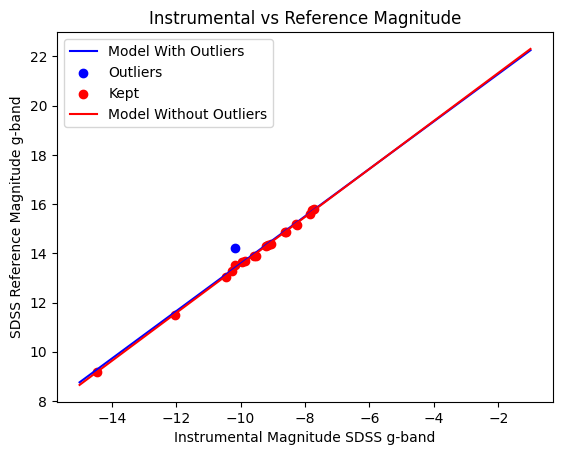

In [5]:
#building calibration model:

res = []
mag_thresh = 16


inst_mags = [np.mean(source['instrumental_mags']) for source in sources if source['g_mag'] != None and source['g_mag'] < mag_thresh]
print(len(inst_mags))
sky_mags = [source['g_mag'] for source in sources if source['g_mag'] != None and source['g_mag'] < mag_thresh]

#Makes linear model for calibration:
#This is the first round of modeling, with outliers.
p0 = np.polyfit(inst_mags, sky_mags, deg = 1)
x = np.arange(-15, 0)
y = p0[0]*x + p0[1]
plt.plot(x, y, color = 'b', label = "Model With Outliers")
diffs = [s['g_mag']- (np.mean(s['instrumental_mags'])*p0[0] + p0[1]) for s in sources if s['g_mag'] != None and s['g_mag'] < mag_thresh]
stdv = np.std(diffs)

inst_mags_final = []
sky_mags_final = []
outlier_inst =[]
outlier_sky =[]

for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
    if diff < stdv:
        i = diffs.index(diff)
        inst_mags_final.append(inst_mags[i])
        sky_mags_final.append(sky_mags[i])
    else:
        i = diffs.index(diff)
        outlier_inst.append(inst_mags[i])
        outlier_sky.append(sky_mags[i])
p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1) #recalculates calibration model without outliers.
#p2 = np.polyfit(inst_mags_final, sky_mags_final, deg = 0)
#print(p2[0])
print("first try: {}".format(p0)) #prints slopes of each model. In theory, they should come out to around 1.
print("second try: {}".format(p1))


plt.scatter(outlier_inst, outlier_sky, color = 'b', label = "Outliers")
plt.scatter(inst_mags_final, sky_mags_final, color = 'r', label = "Kept")
plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers")
#plt.plot(x, [i+ p1[1] for i in x], color = 'g', label = "unity")
plt.xlabel("Instrumental Magnitude SDSS g-band")
plt.ylabel("SDSS Reference Magnitude g-band")
plt.title("Instrumental vs Reference Magnitude")
plt.legend()
#plt.savefig("F:/SDI/Section32Figures/calibrationplot.png", dpi = 1000)
#plt.savefig("/Users/lucaangeleri/Documents/LCO/sec17figures/calibrationplot.png", dpi = 1000)
plt.show()



#add calibrated mags to sources:
for source in sources:
    vals = []
    for val in source['instrumental_mags']:
        cal = np.float64(val*p1[0] + p1[1])
        vals.append(cal)
    source['calibrated_mags'] = vals #probably a cleaner way to do this part but was having issue where calibrated magnitudes were being added to dict as individual arrays





0.5091411964343014 -0.007583926593397905 2.0037651409072925
[[0.98838186]
 [0.20571612]]
43


c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


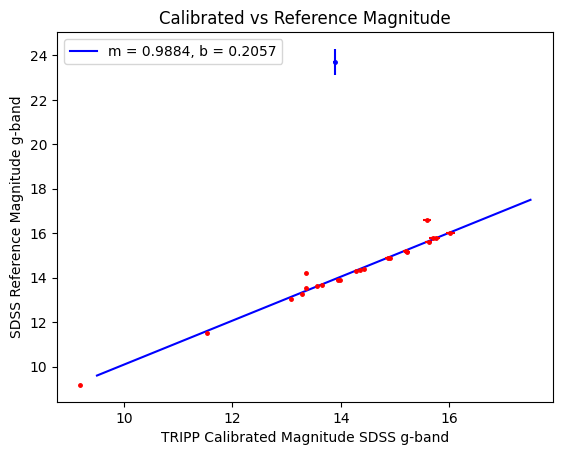

In [6]:
differences = [s['g_mag']- np.mean(s['calibrated_mags']) for s in sources if s['g_mag'] != None]
mean_diff = np.mean(differences)
std_diff = np.std(differences)
med_diff = np.median(differences)
print(mean_diff, med_diff,  std_diff)

X = [np.mean(s['calibrated_mags']) for s in sources if s['g_mag'] != None and s['g_mag'] < mag_thresh]
Y = [s['g_mag'] for s in sources if s['g_mag'] != None and s['g_mag'] < mag_thresh]
p3 = np.polyfit(X, Y, deg = 1)
x_vals = np.arange(9.5, 18.5)
plt.plot(x_vals, [x*p3[0] + p3[1] for x in x_vals], color = 'b', label = 'm = {}, b = {}'.format("%.4f" % p3[0], "%.4f" % p3[1]))


print(p3)

for s in sources:
    if s['g_mag'] != None and abs(s['g_mag'] - np.mean(s['calibrated_mags'])) > 3*std_diff:
        plt.errorbar(np.mean(s['calibrated_mags']), s['g_mag'], xerr= np.median(s['inst_mag_errs']), yerr= s['g_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'b')
        print(s['source_id'])
    else:
        plt.errorbar(np.mean(s['calibrated_mags']), s['g_mag'], xerr= np.median(s['inst_mag_errs']), yerr= s['g_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'r' )



plt.title("Calibrated vs Reference Magnitude")
plt.xlabel("TRIPP Calibrated Magnitude SDSS g-band")
plt.ylabel("SDSS Reference Magnitude g-band")
plt.legend()
#plt.savefig("/Users/lucaangeleri/Documents/LCO/sec17figures/magdifferences.png", format = 'png', dpi = 1000)
plt.show()


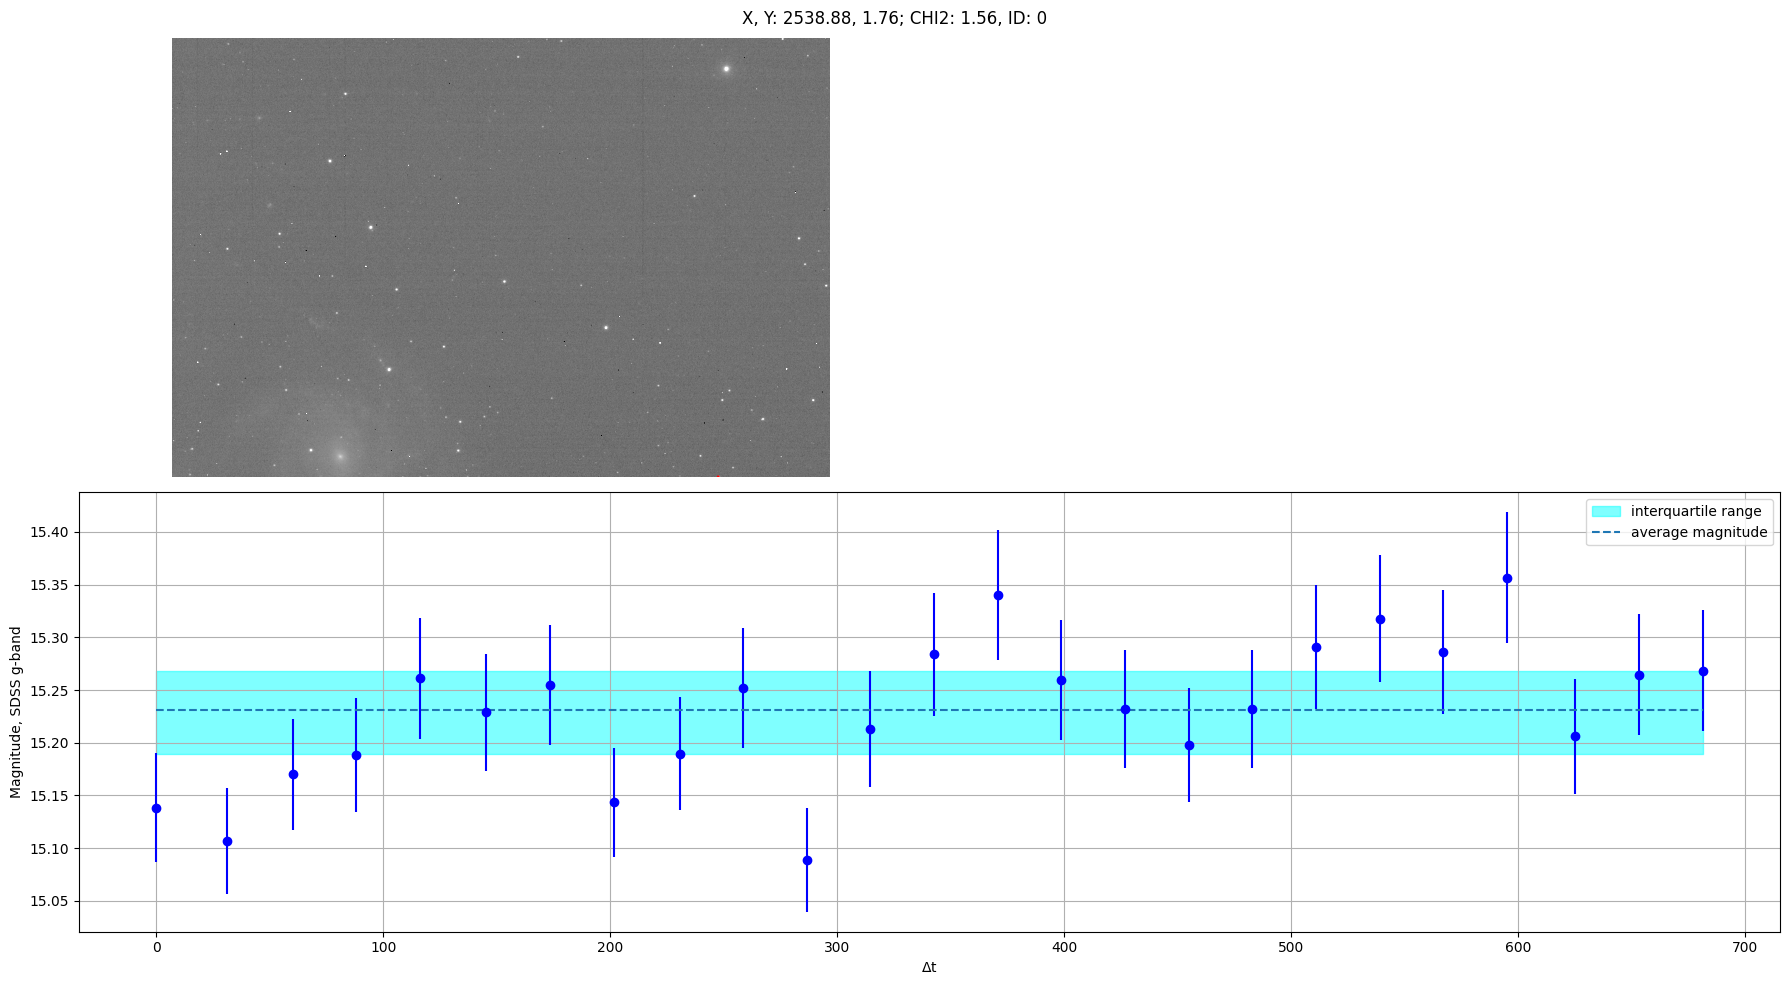

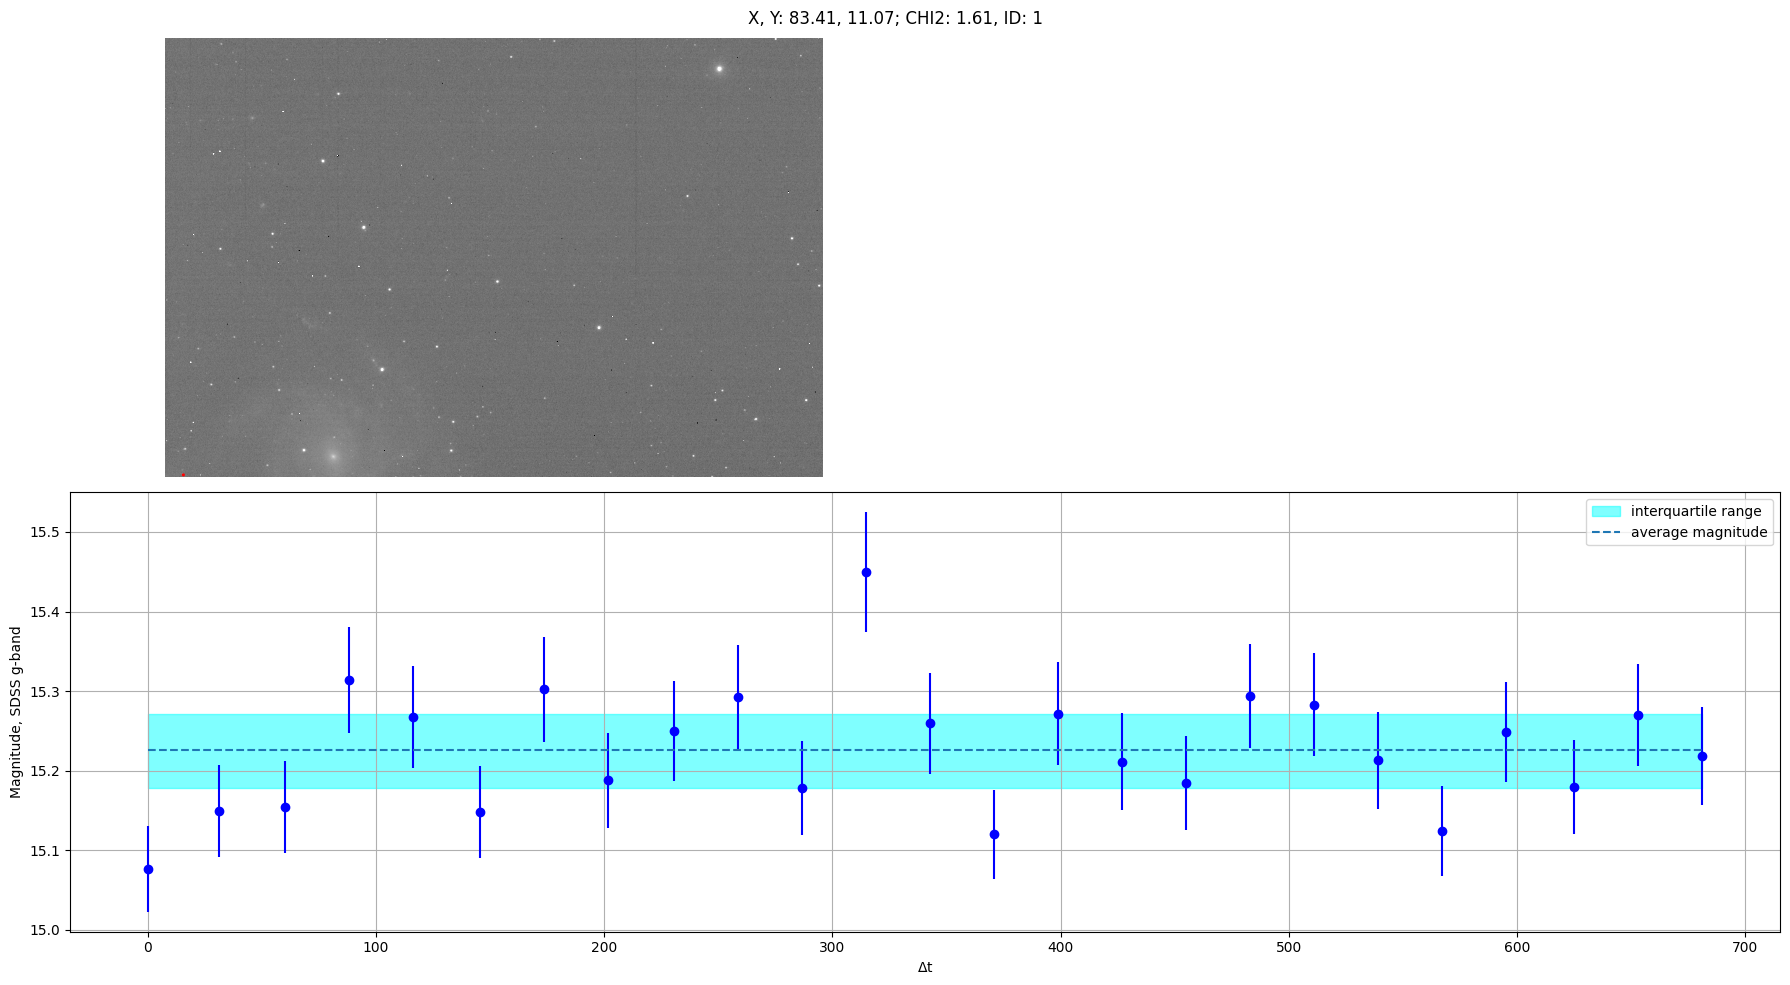

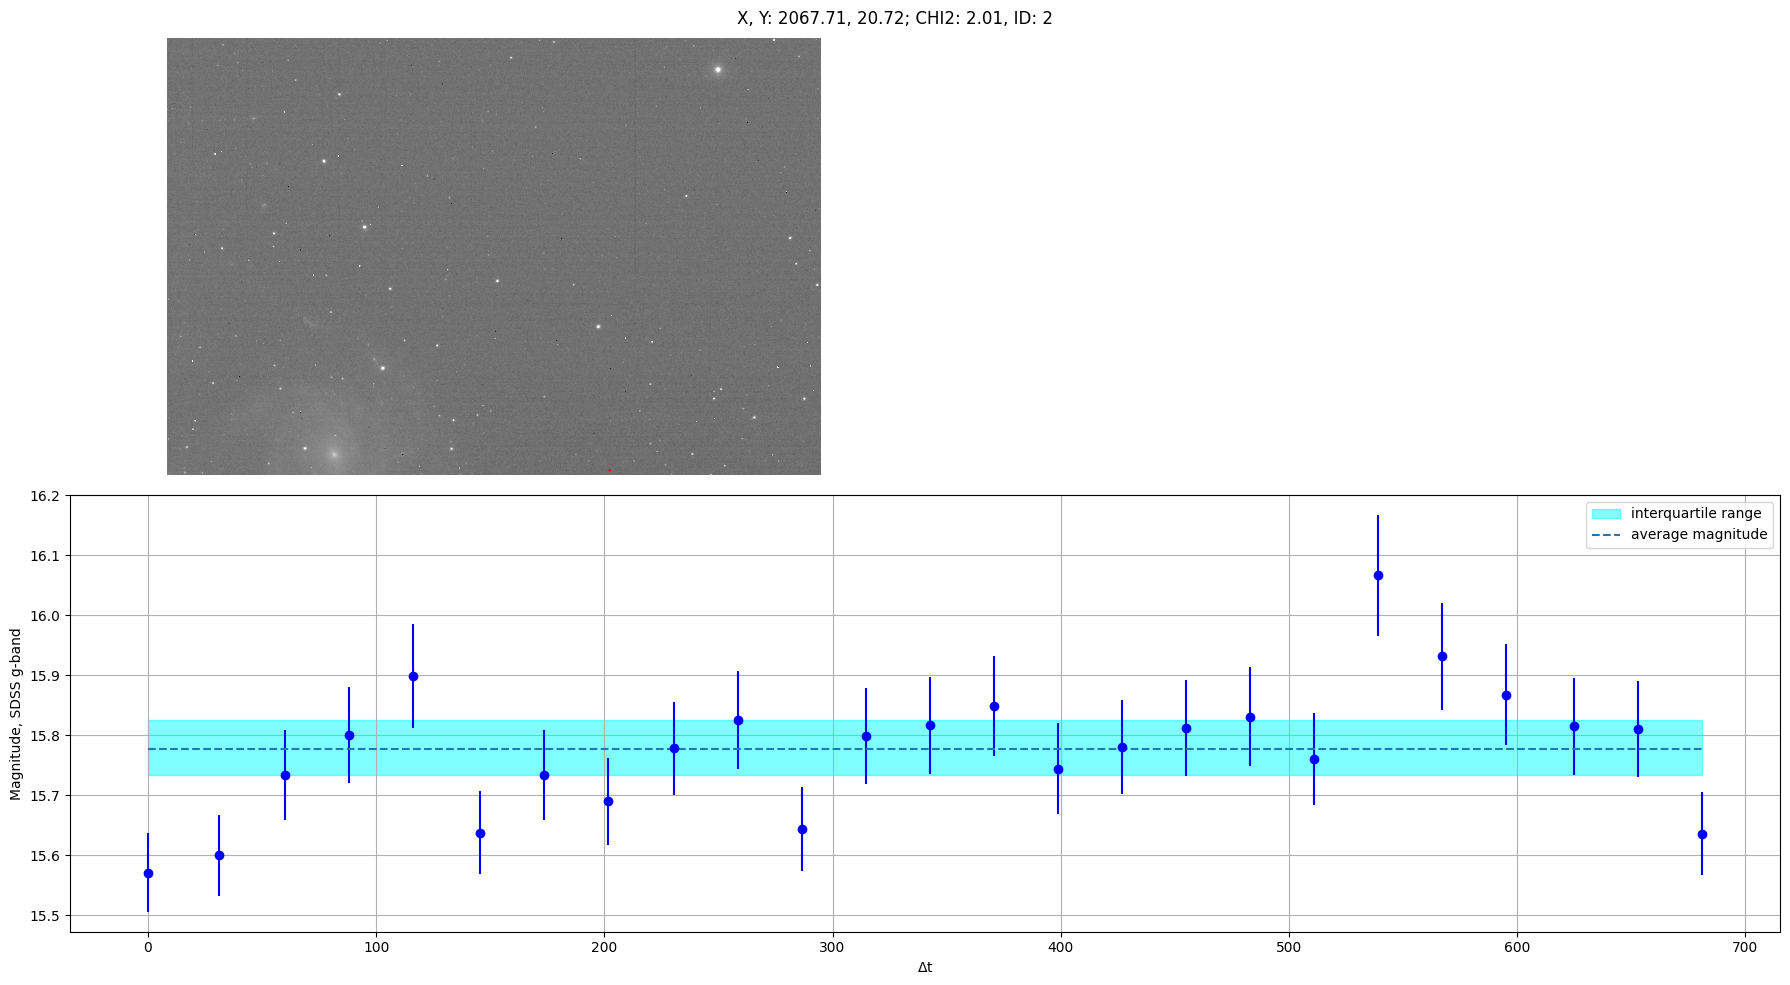

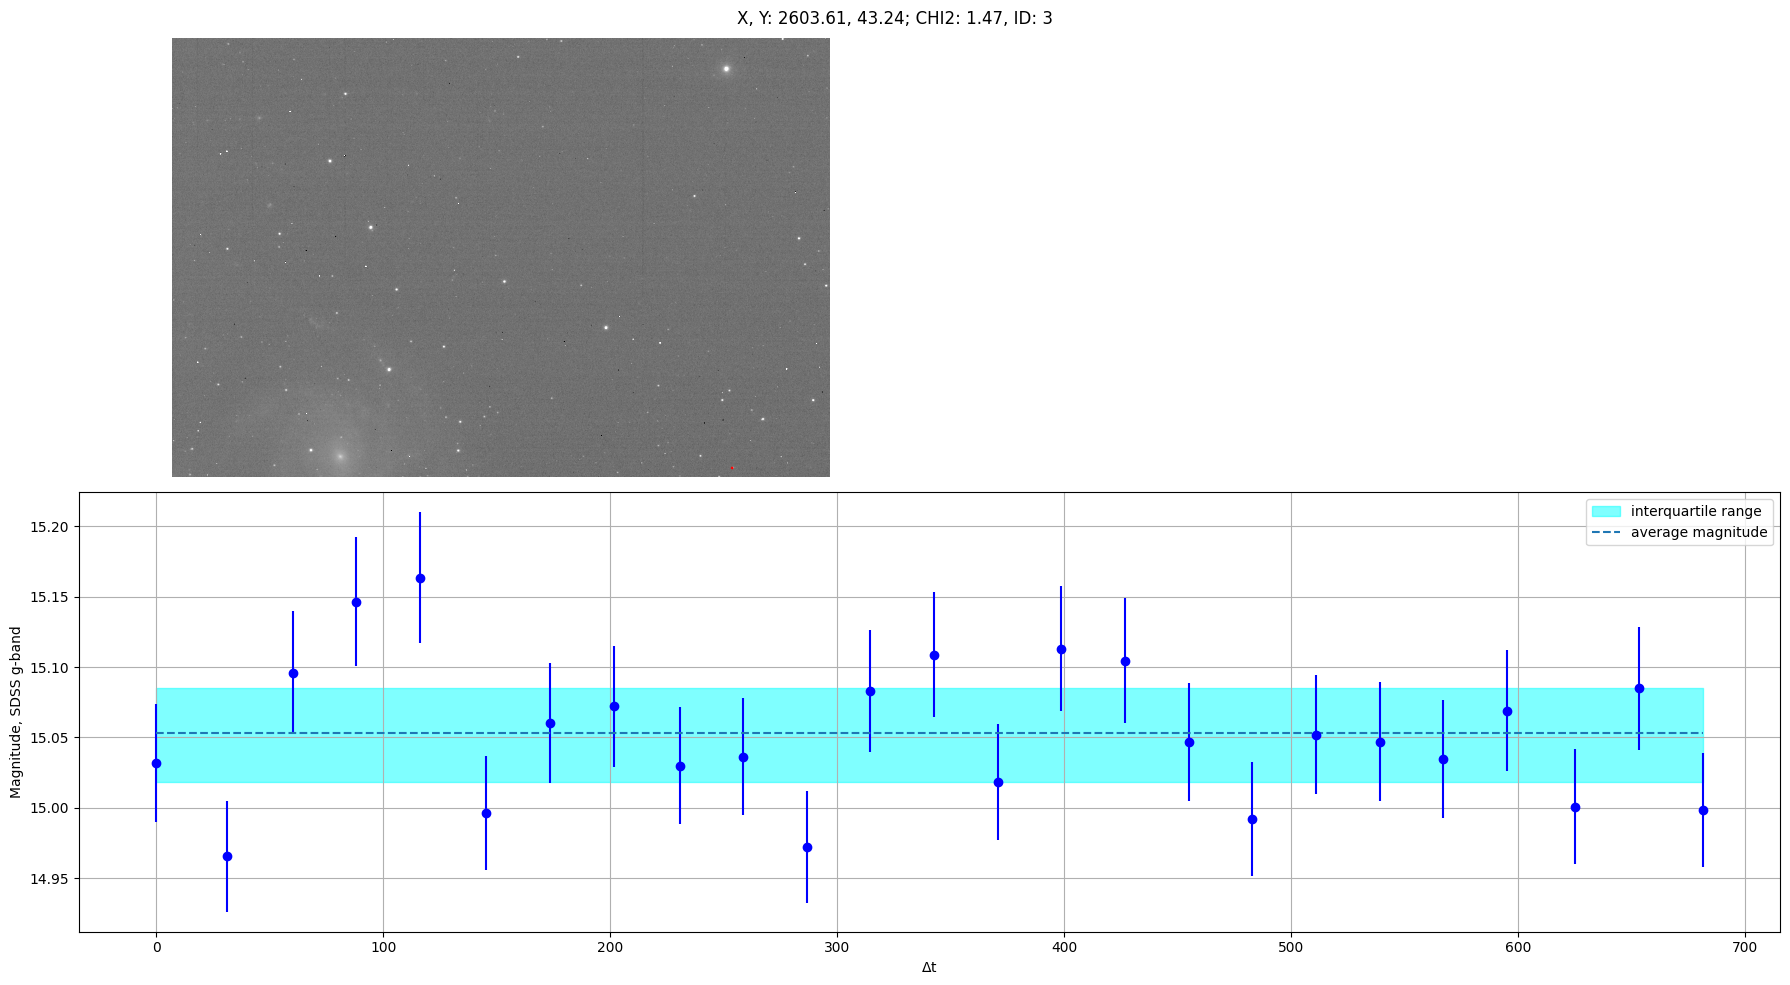

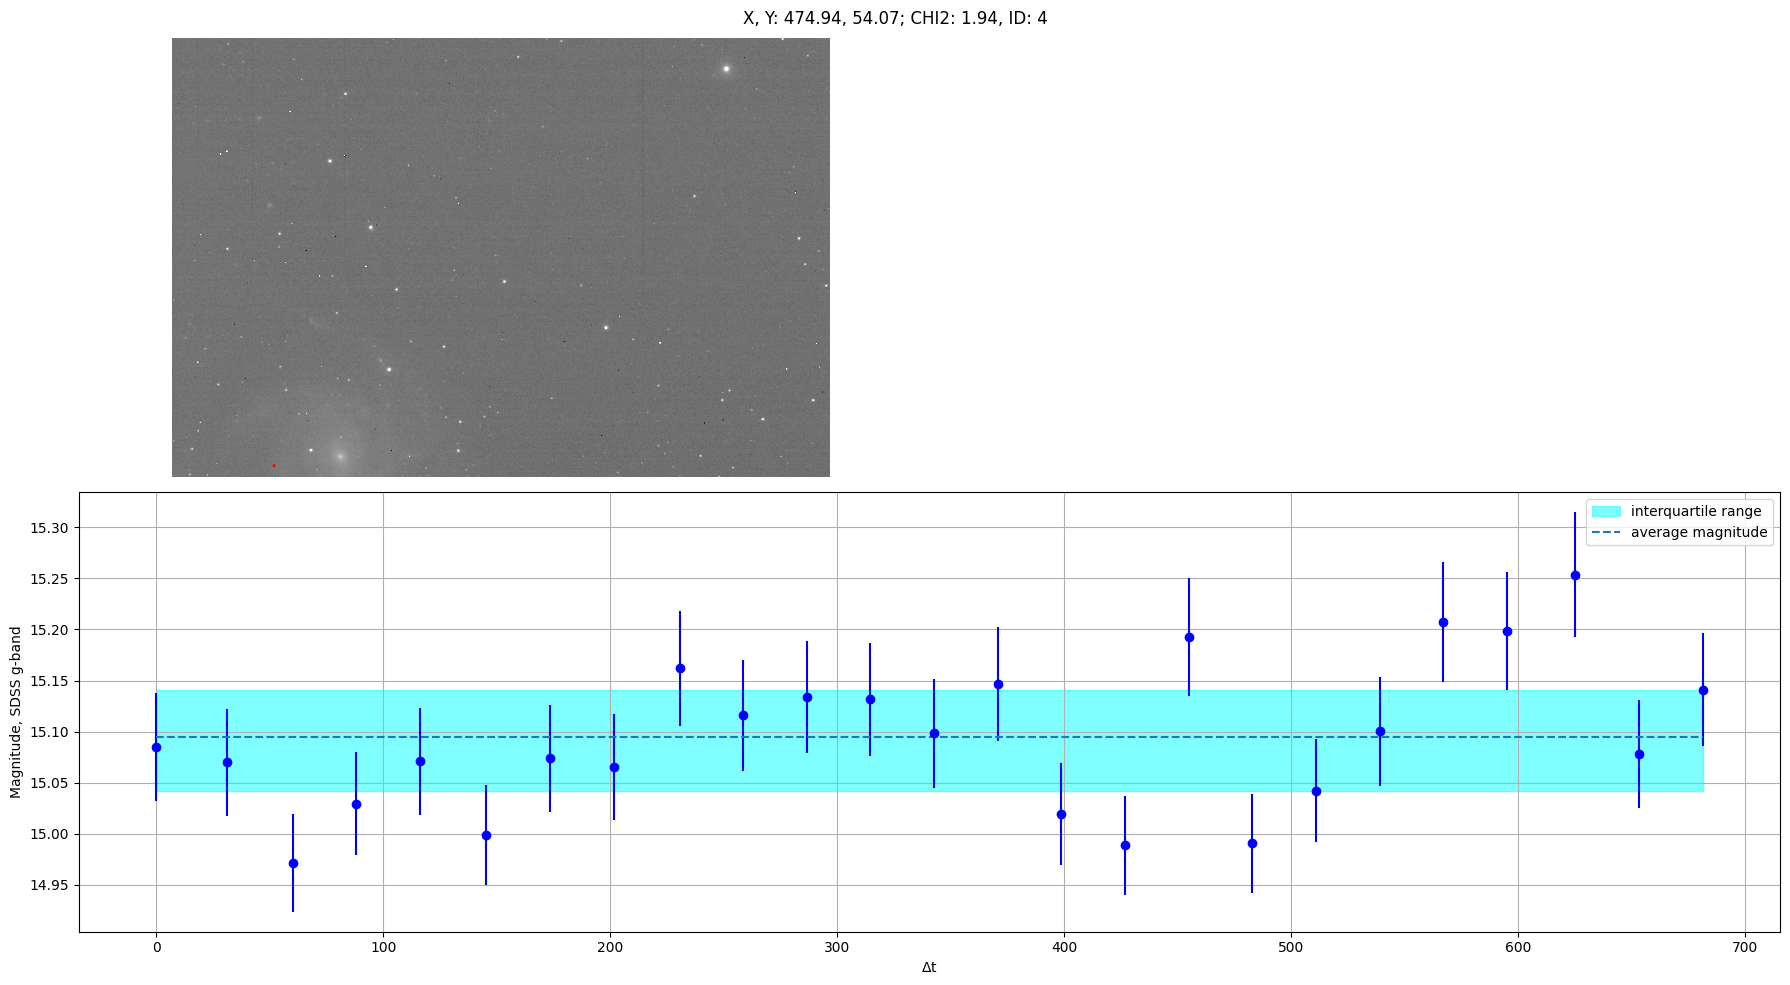

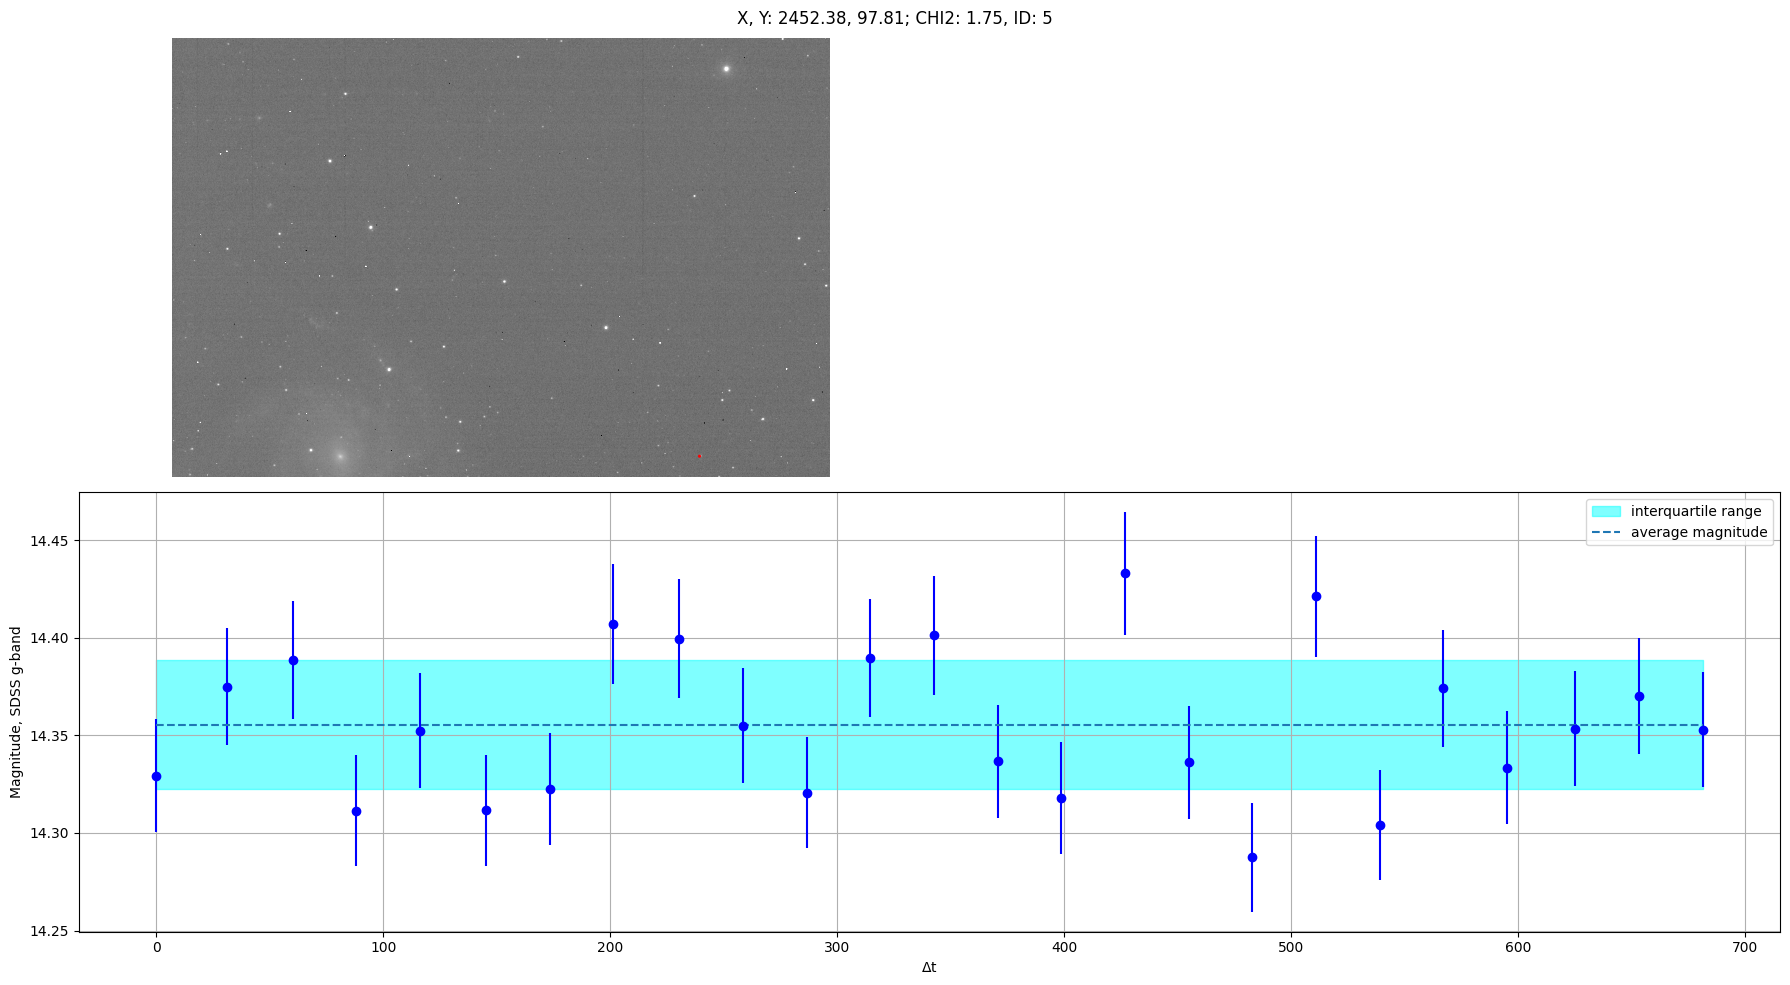

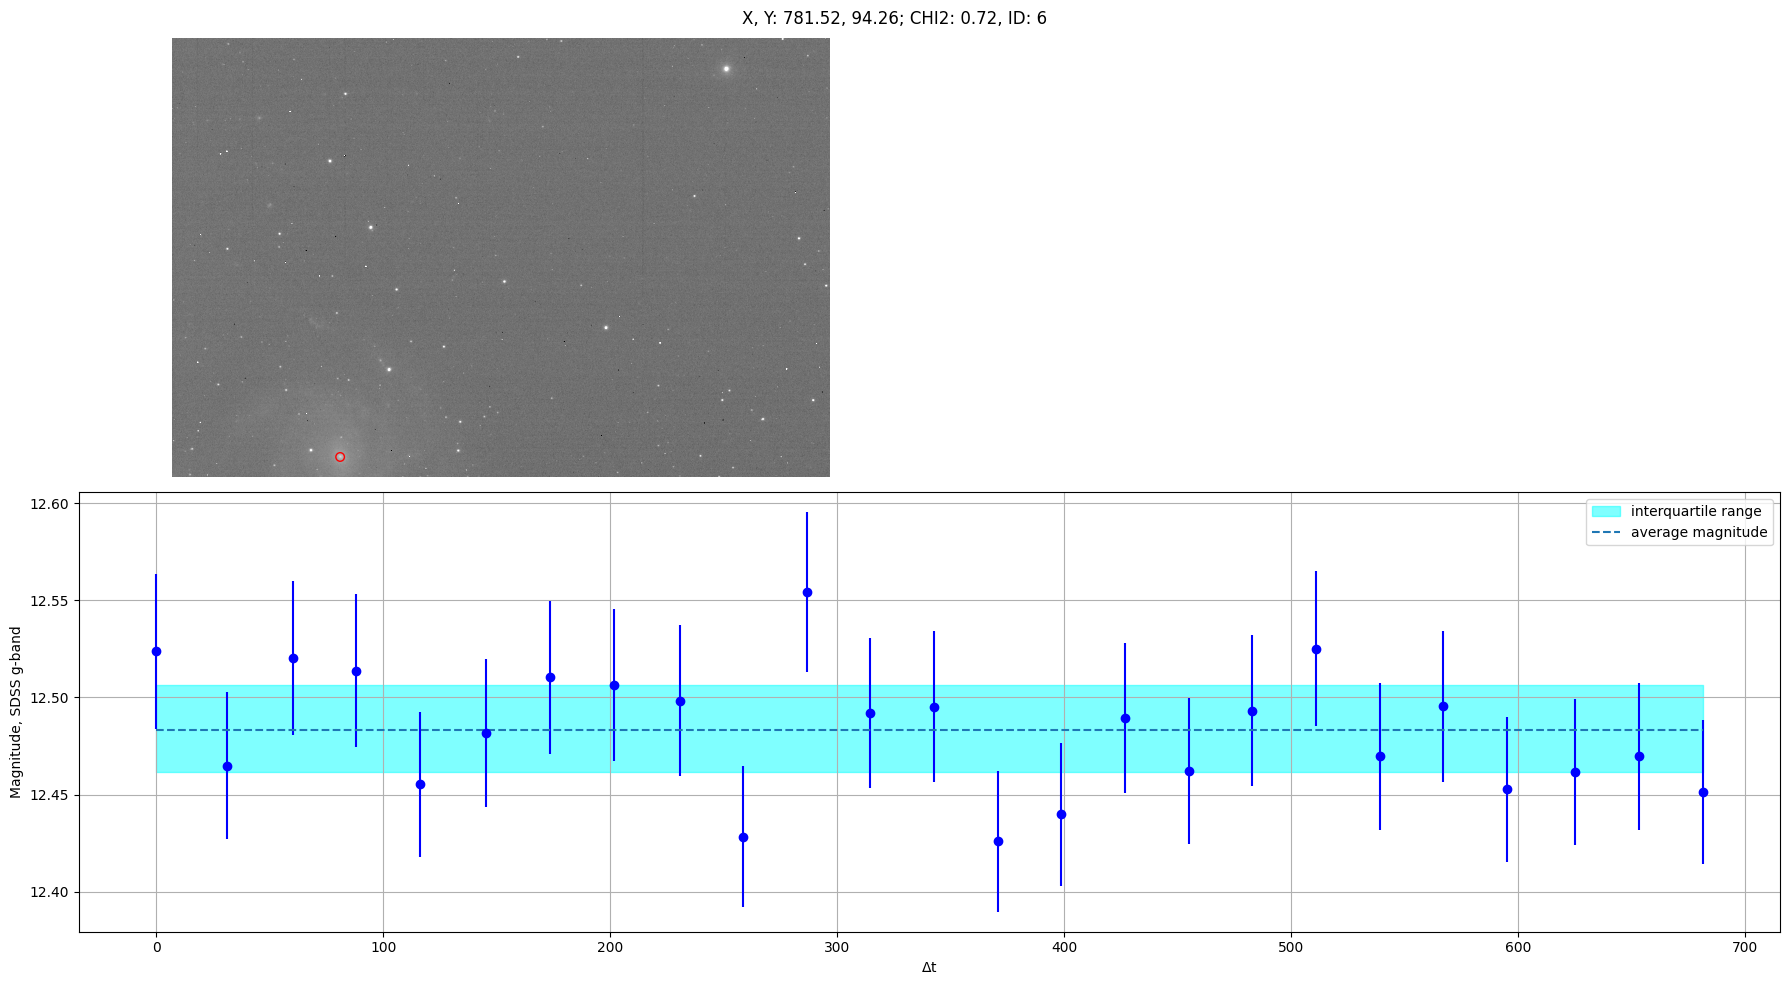

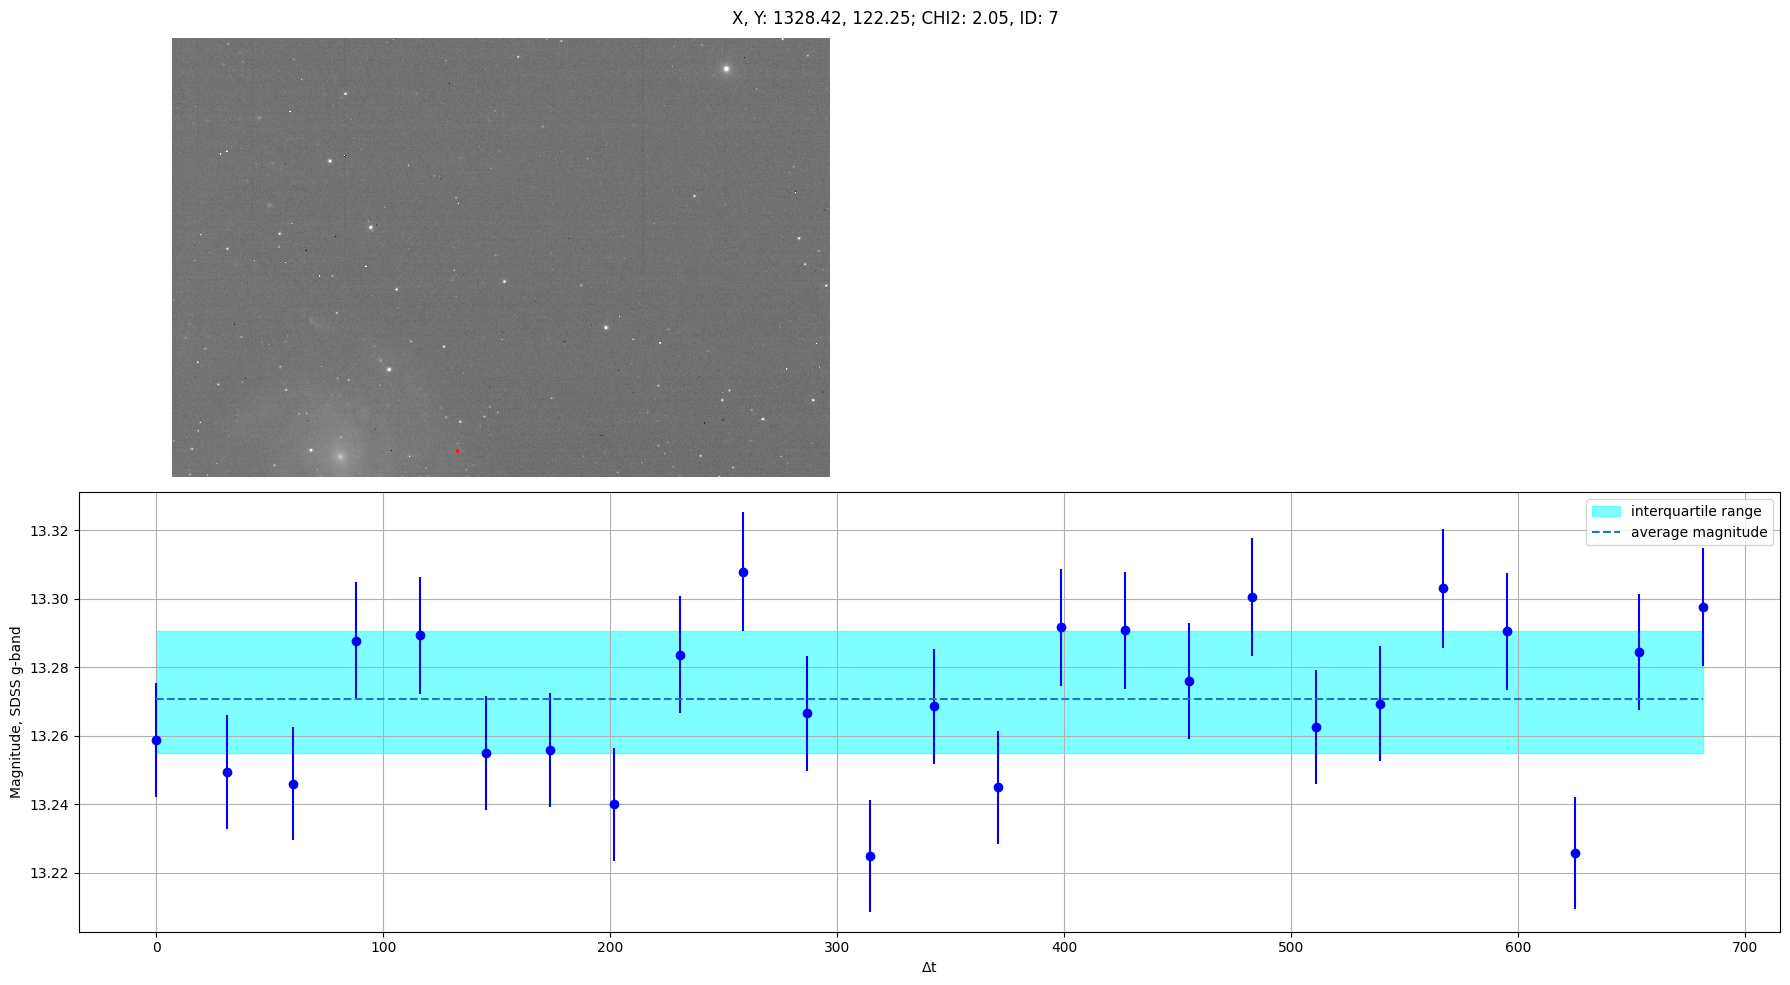

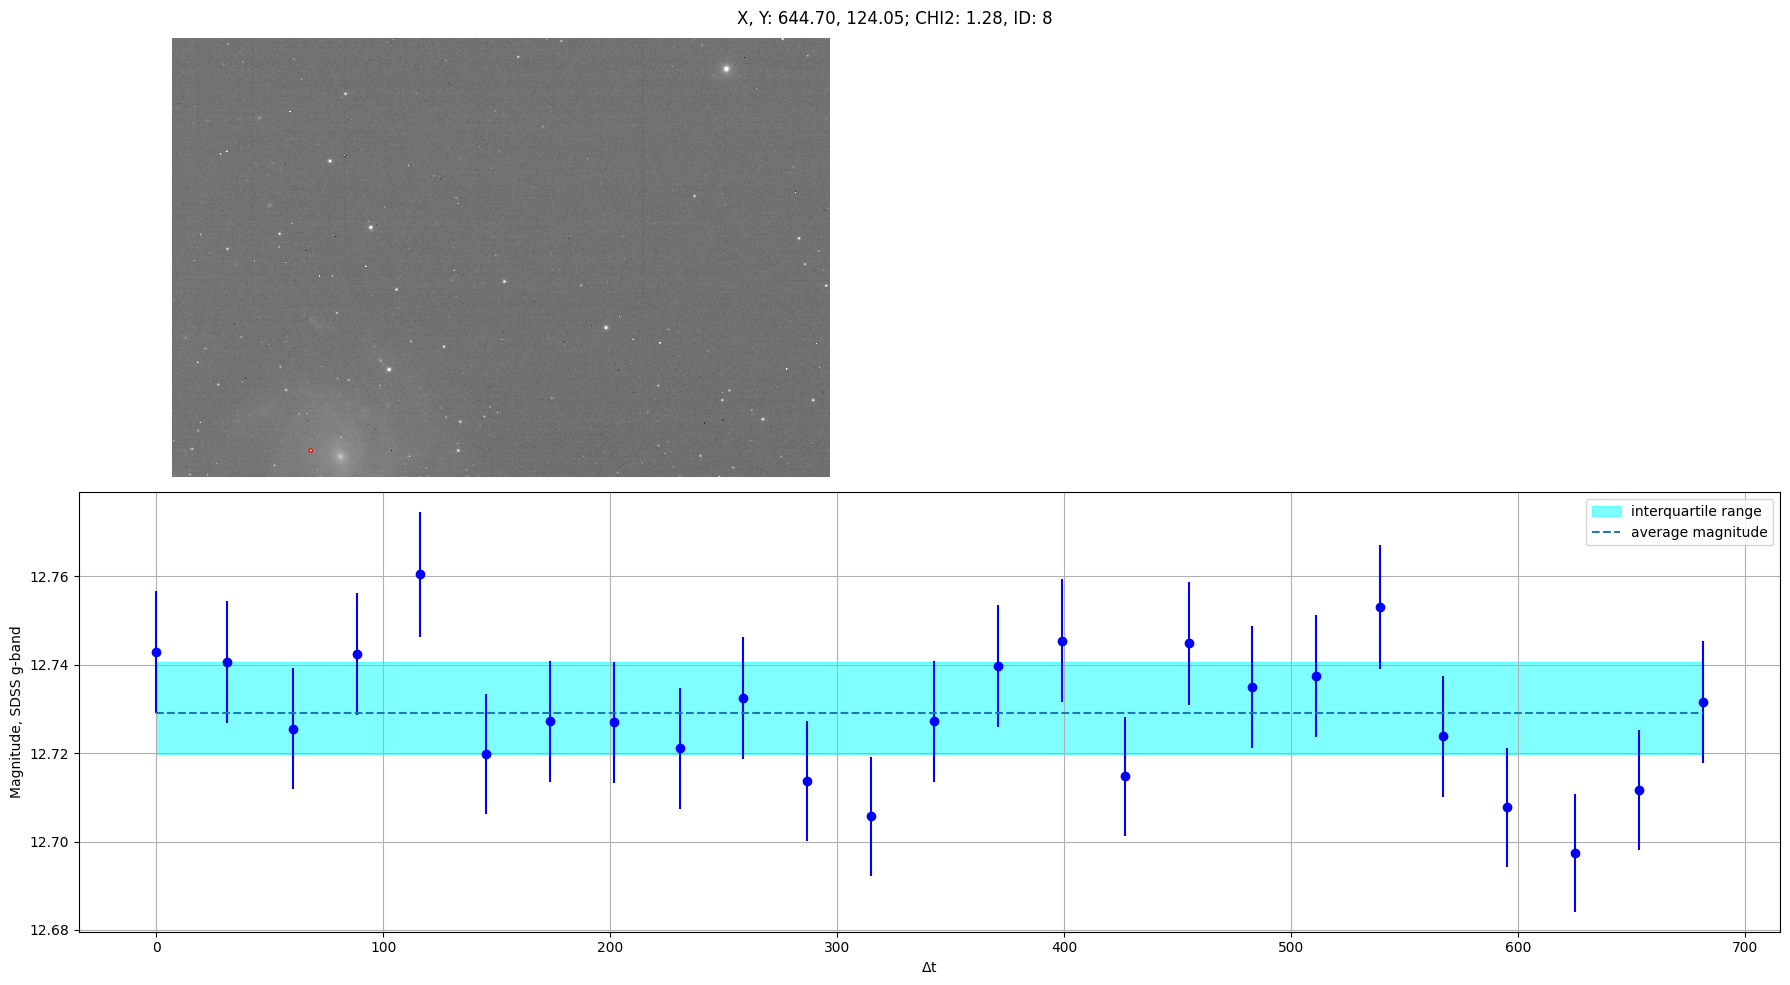

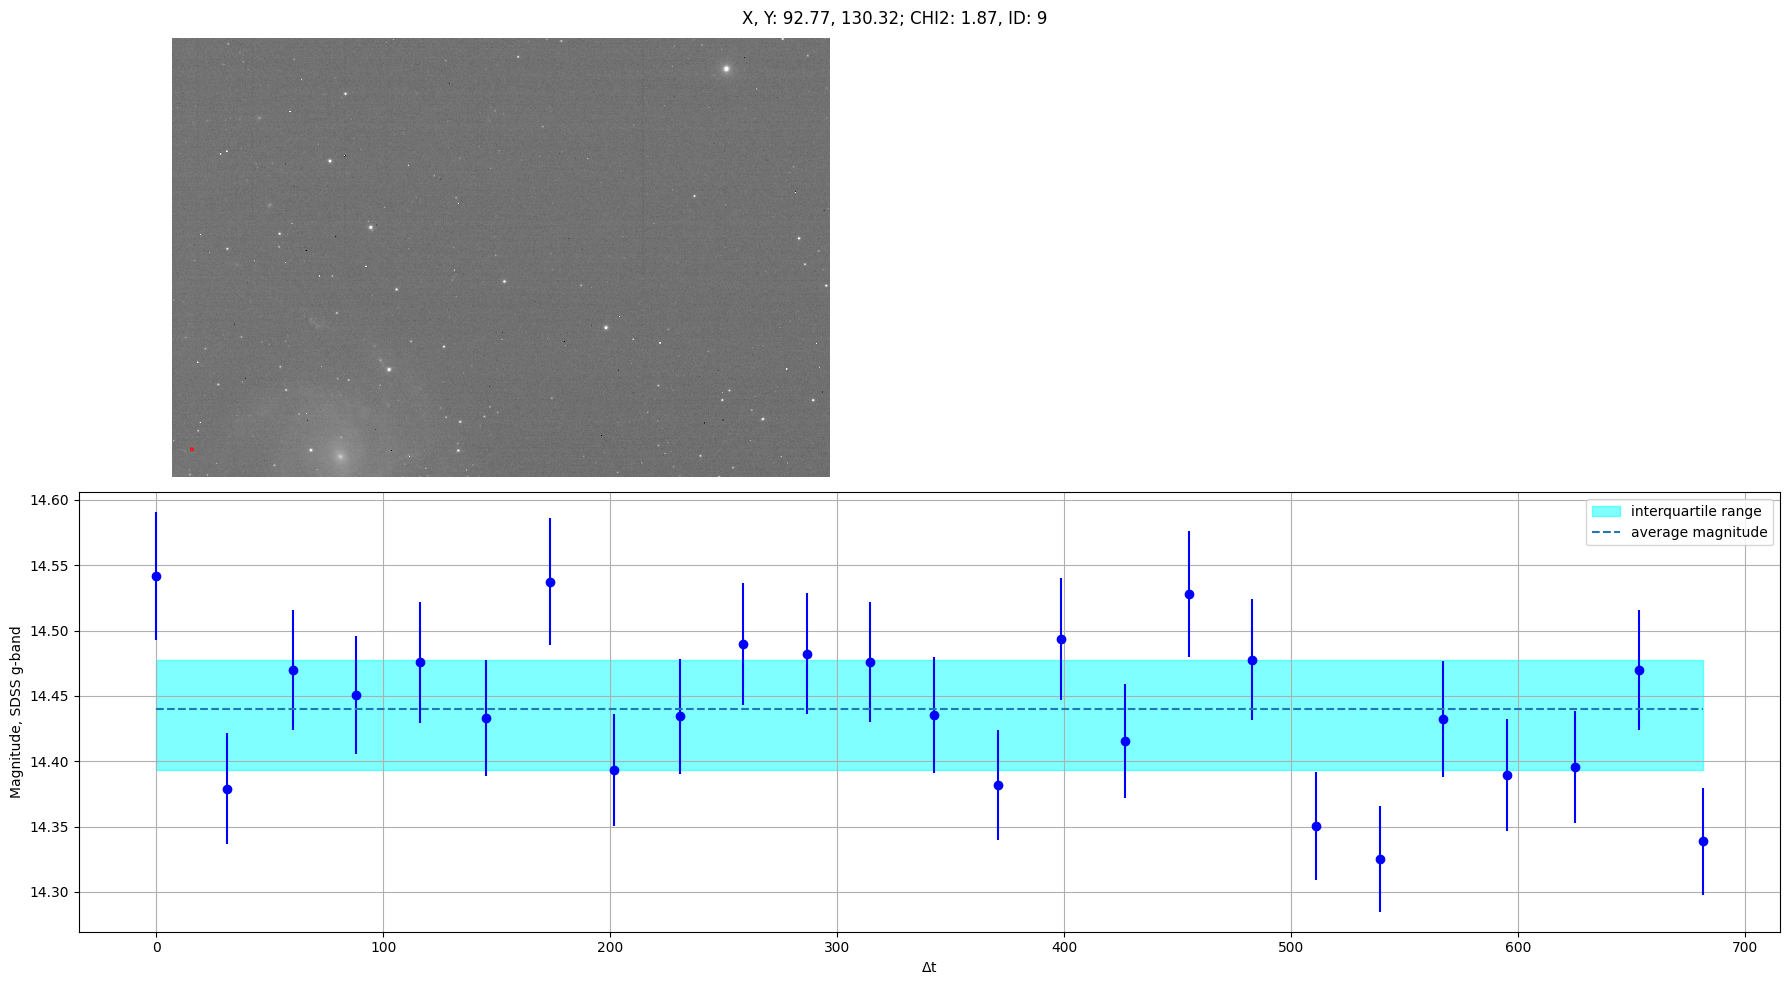

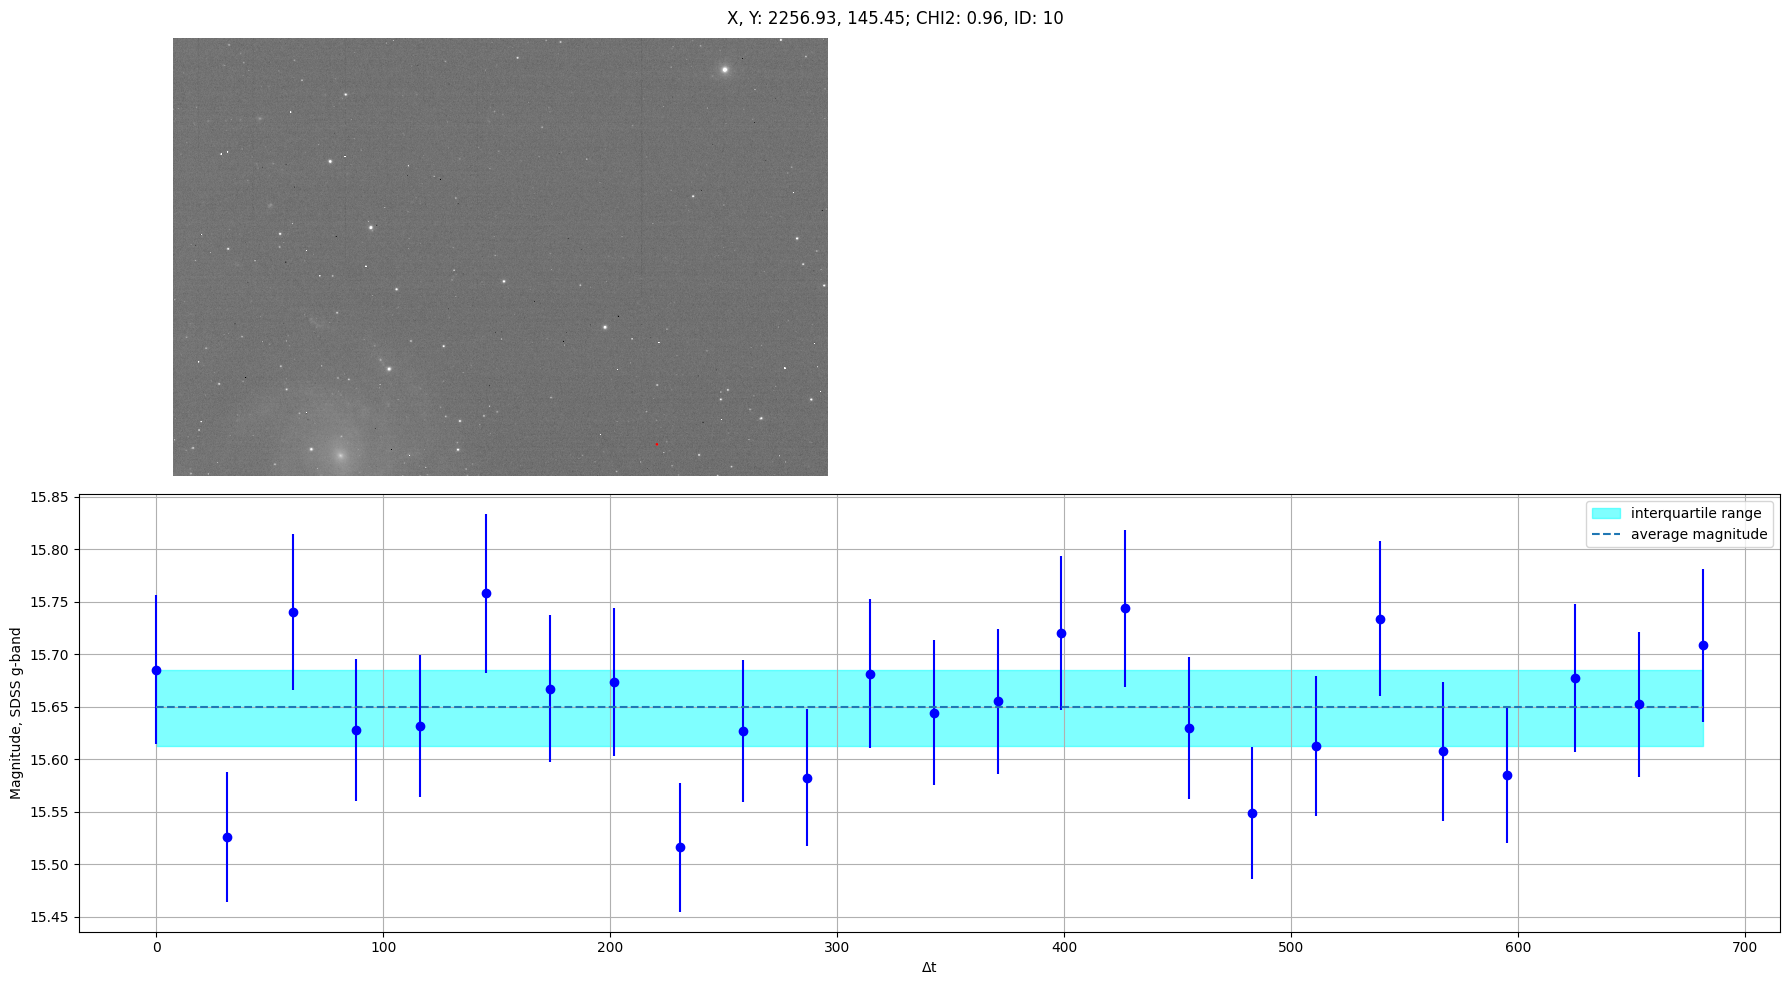

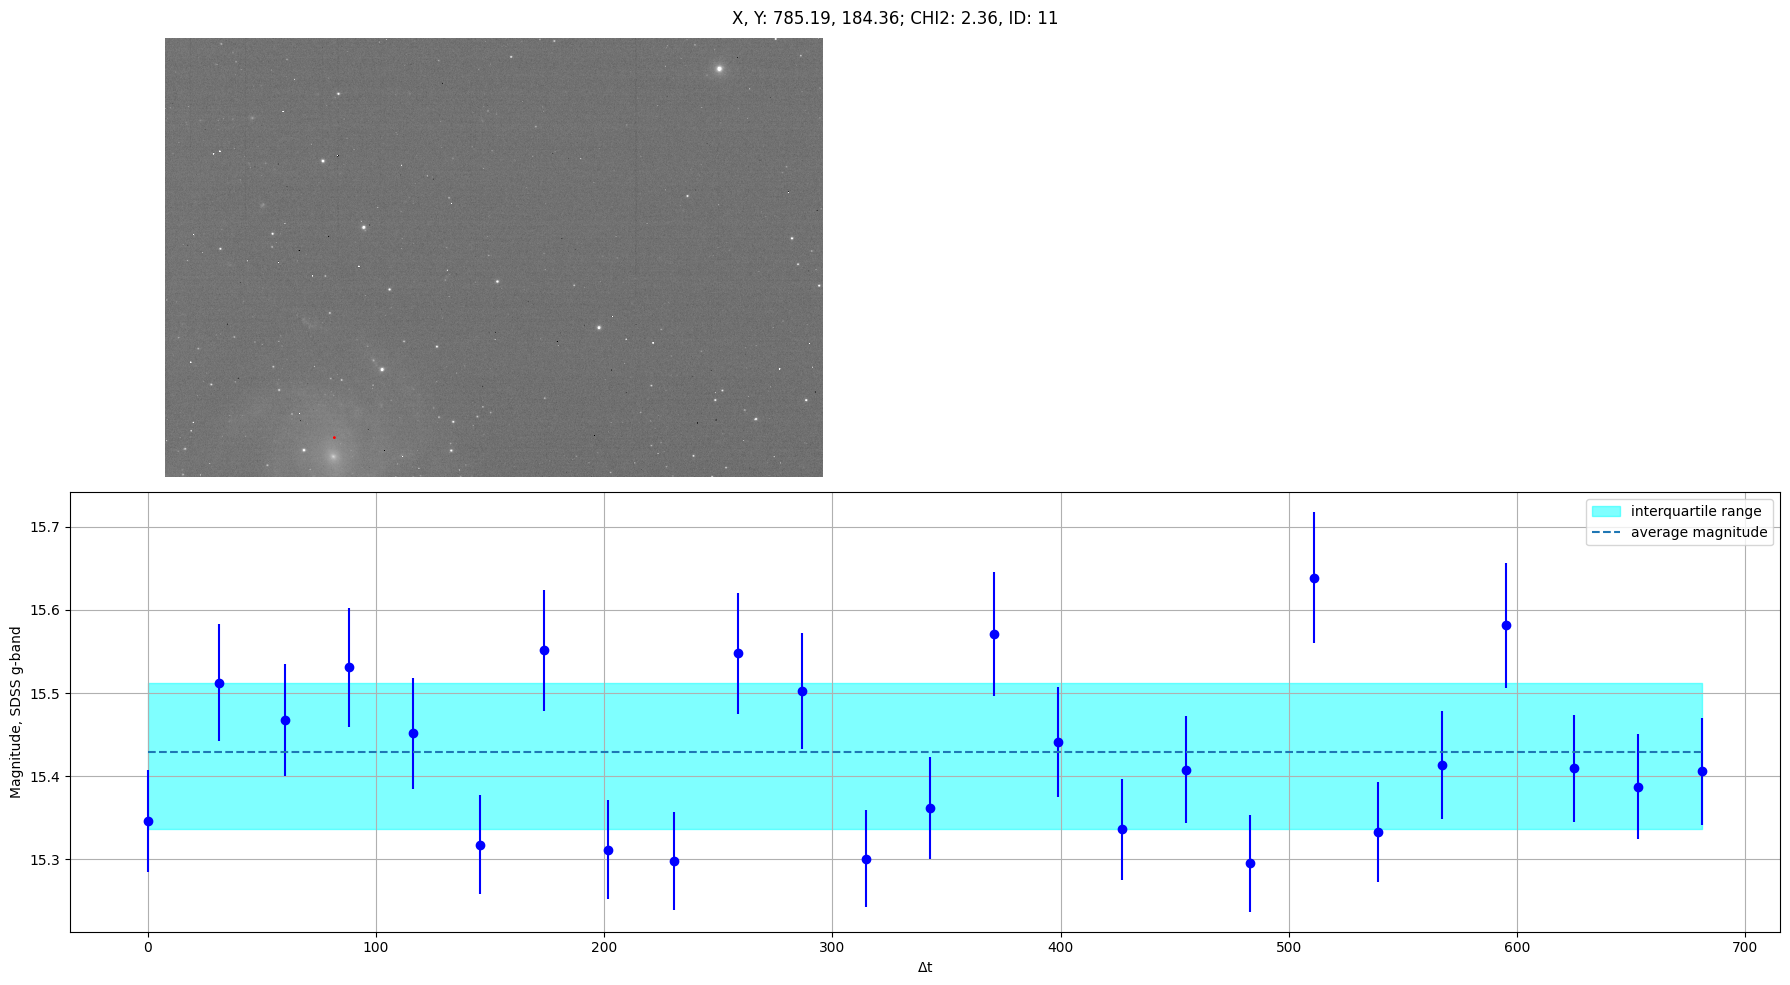

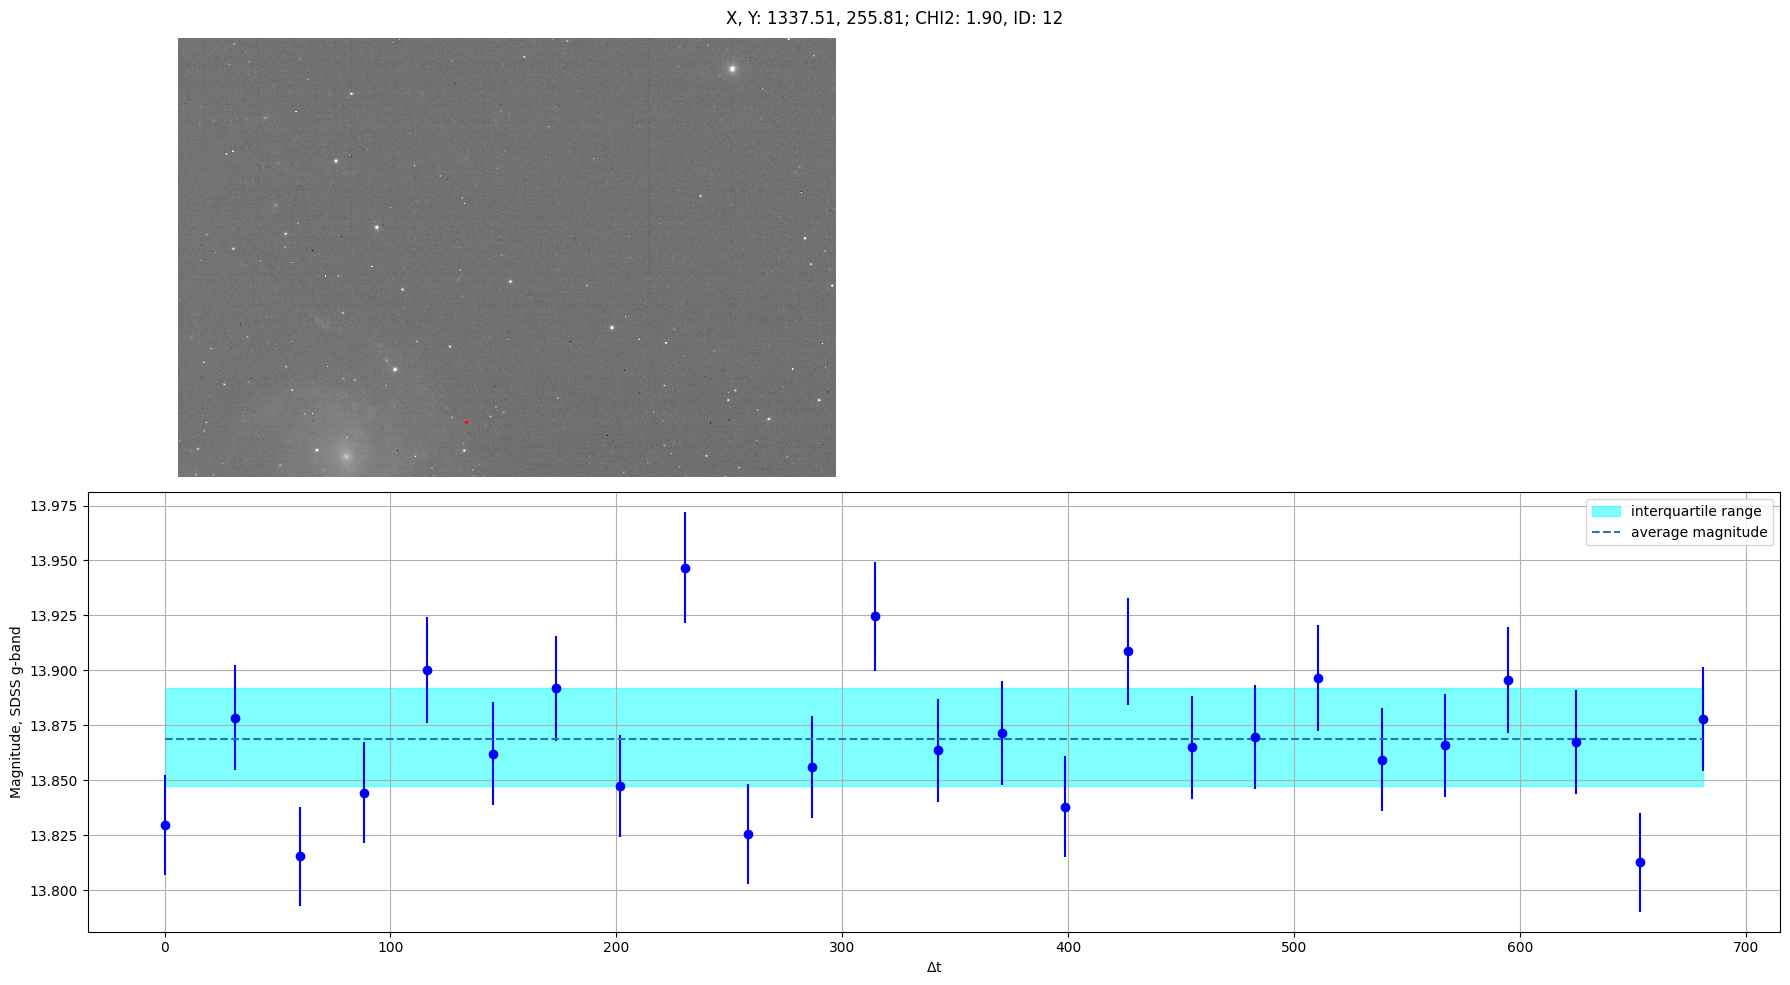

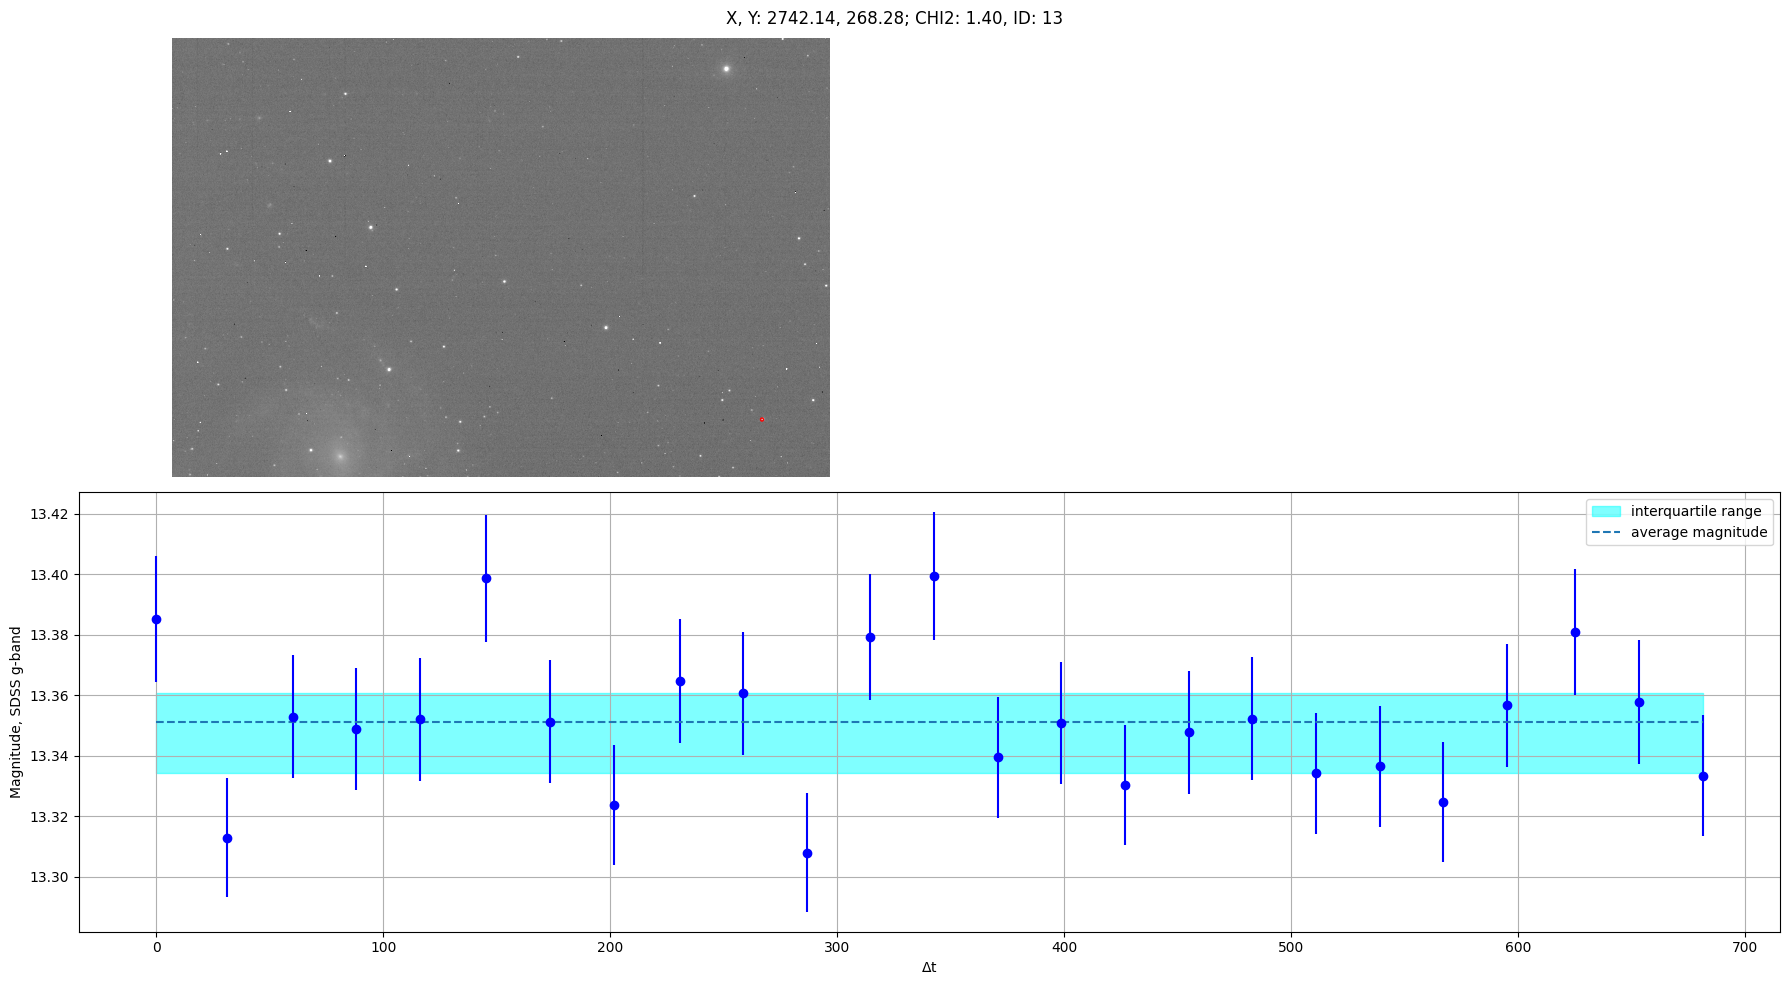

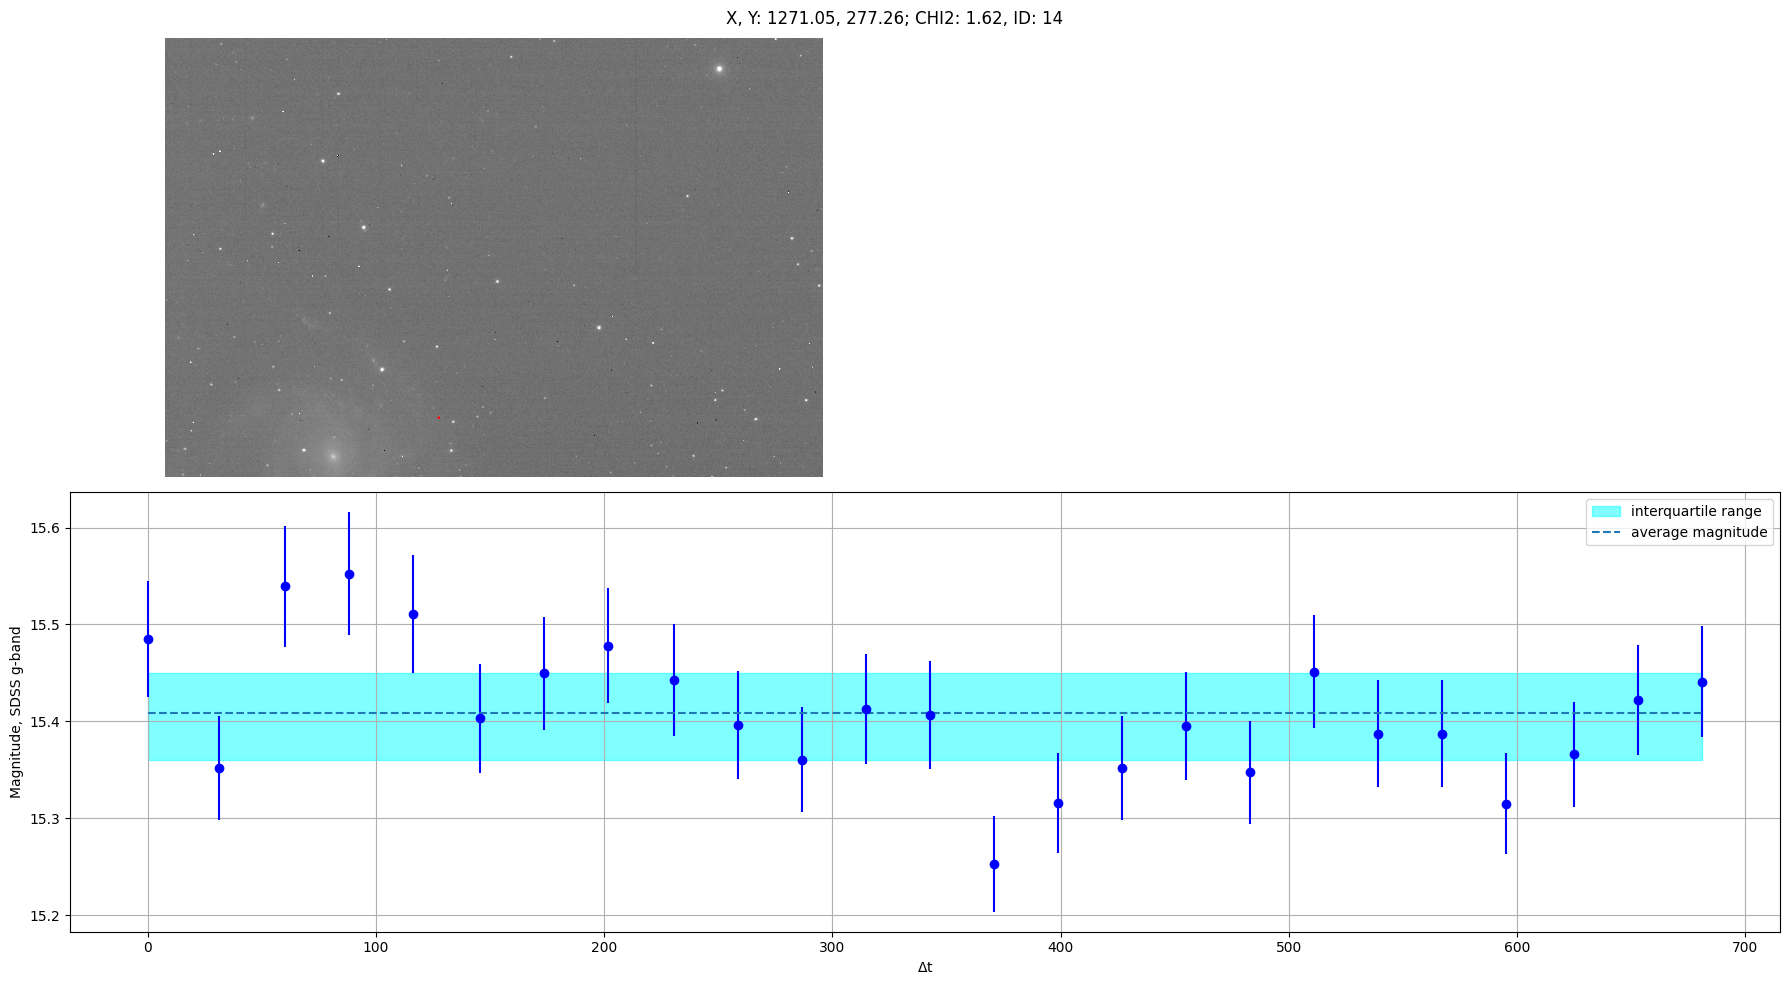

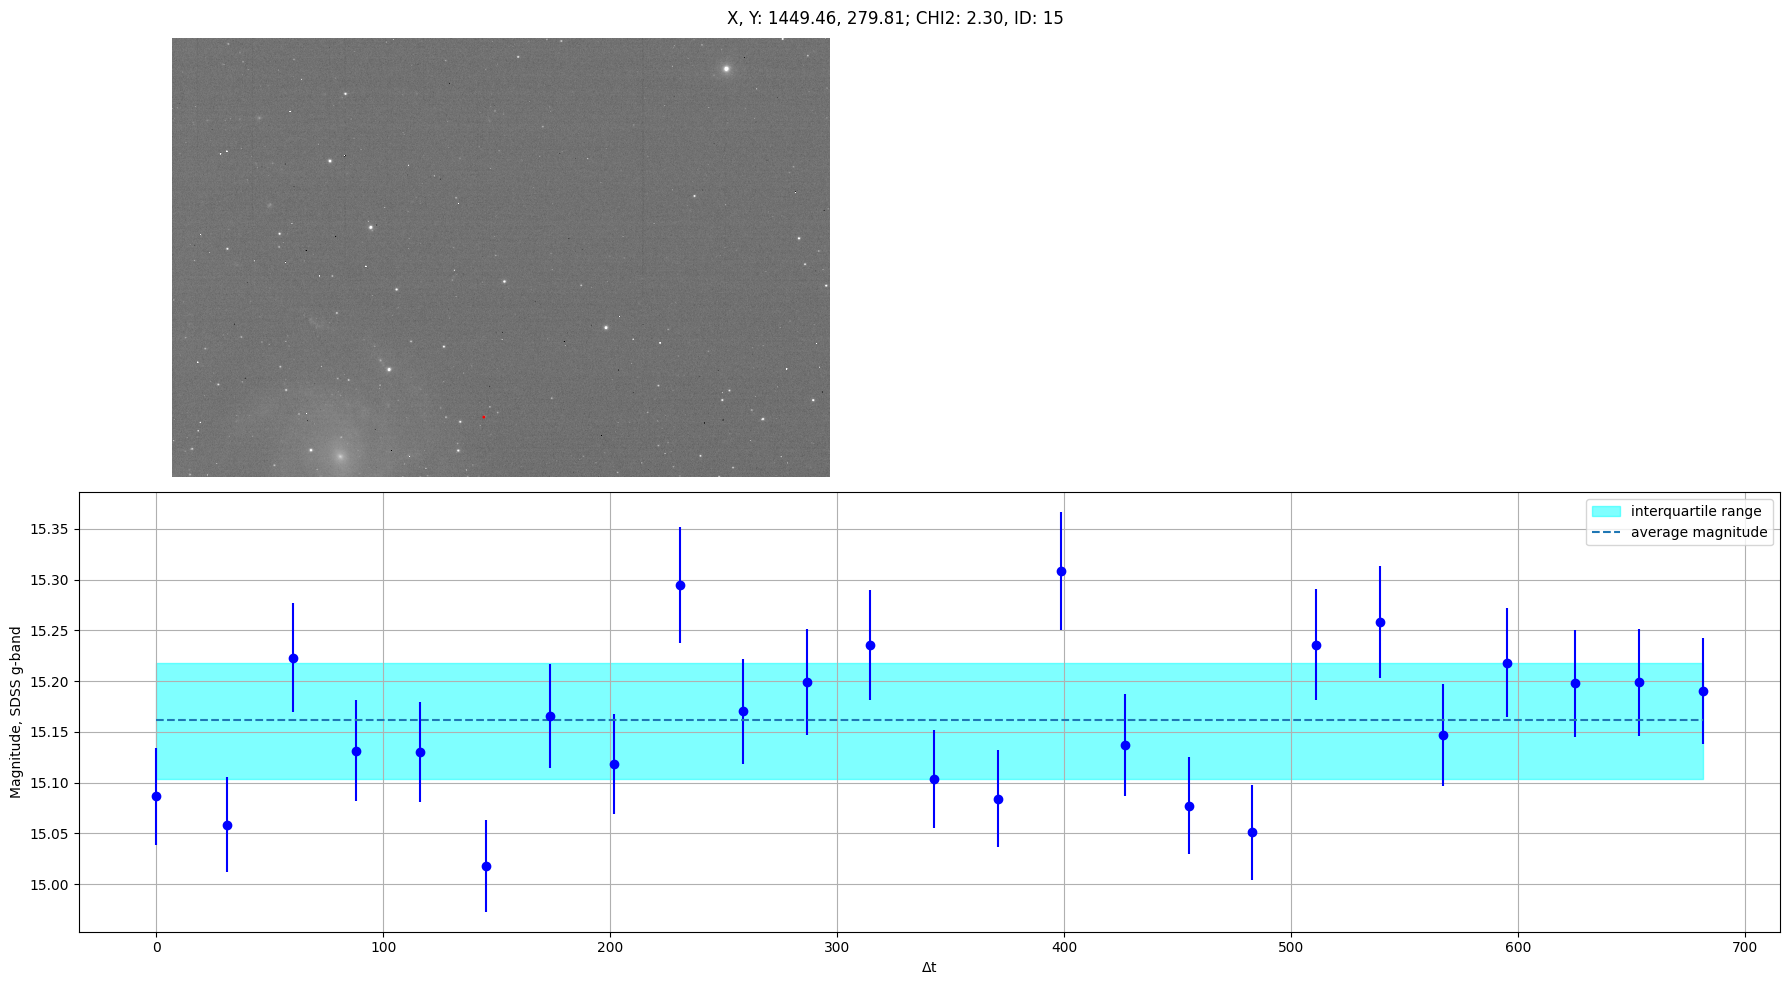

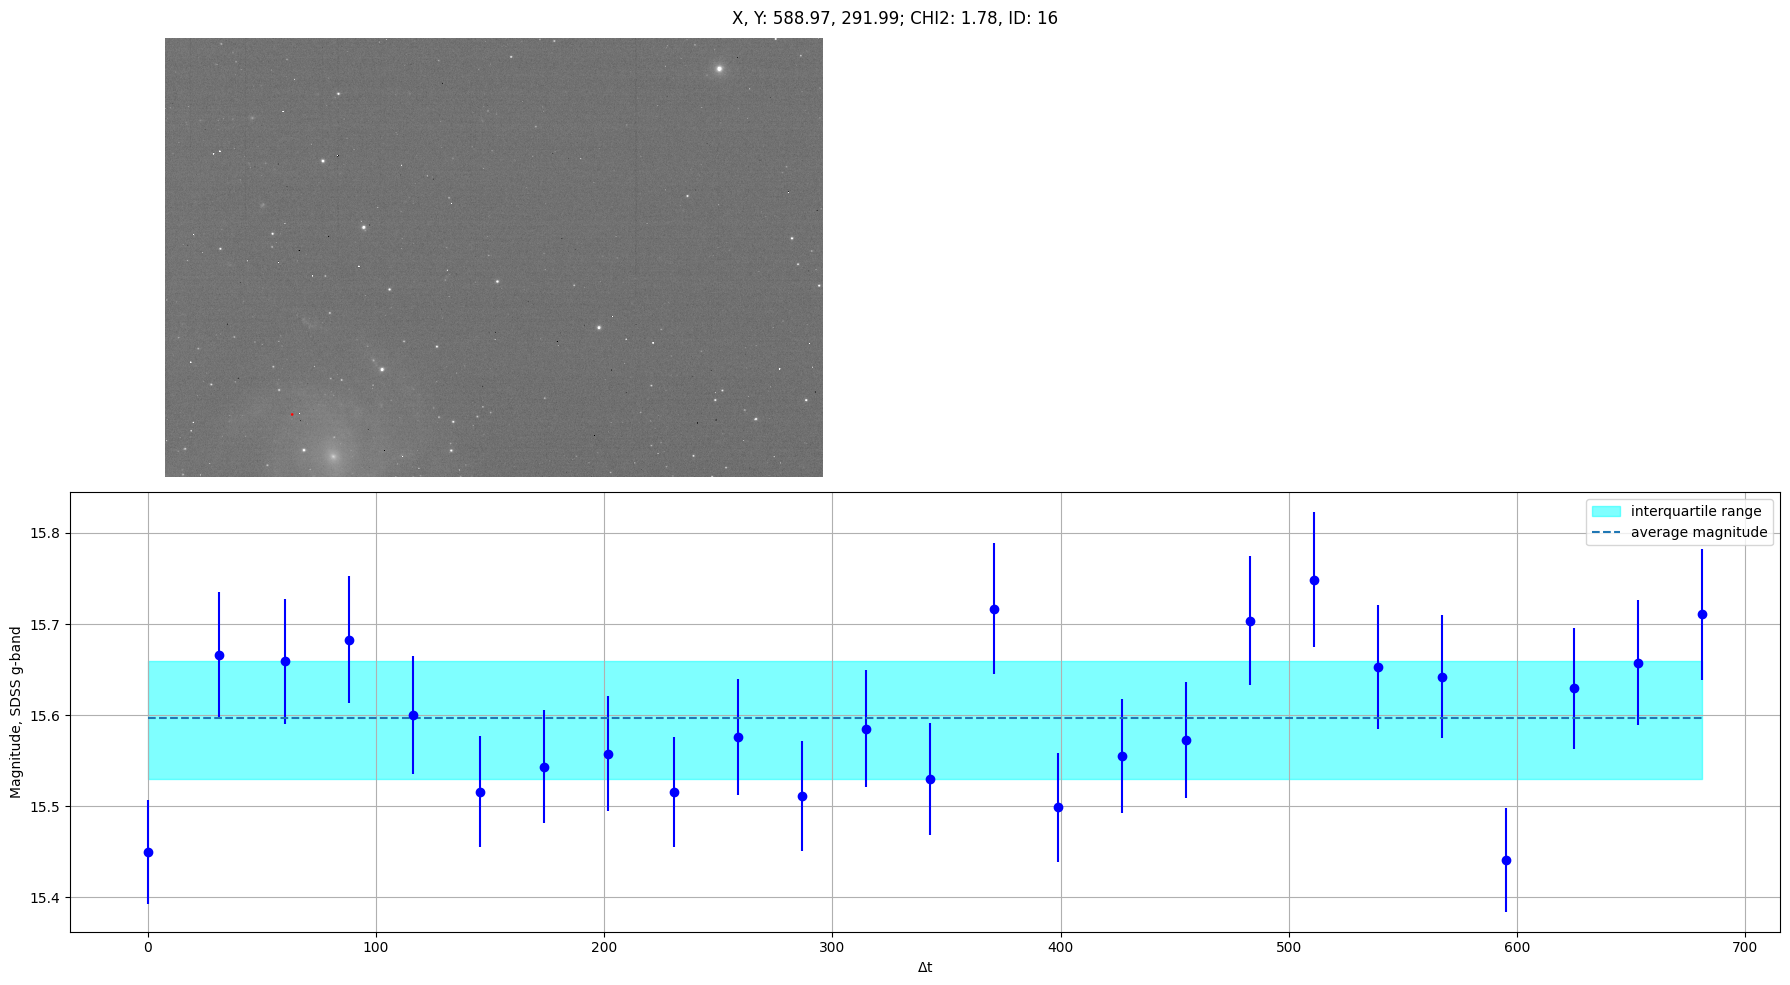

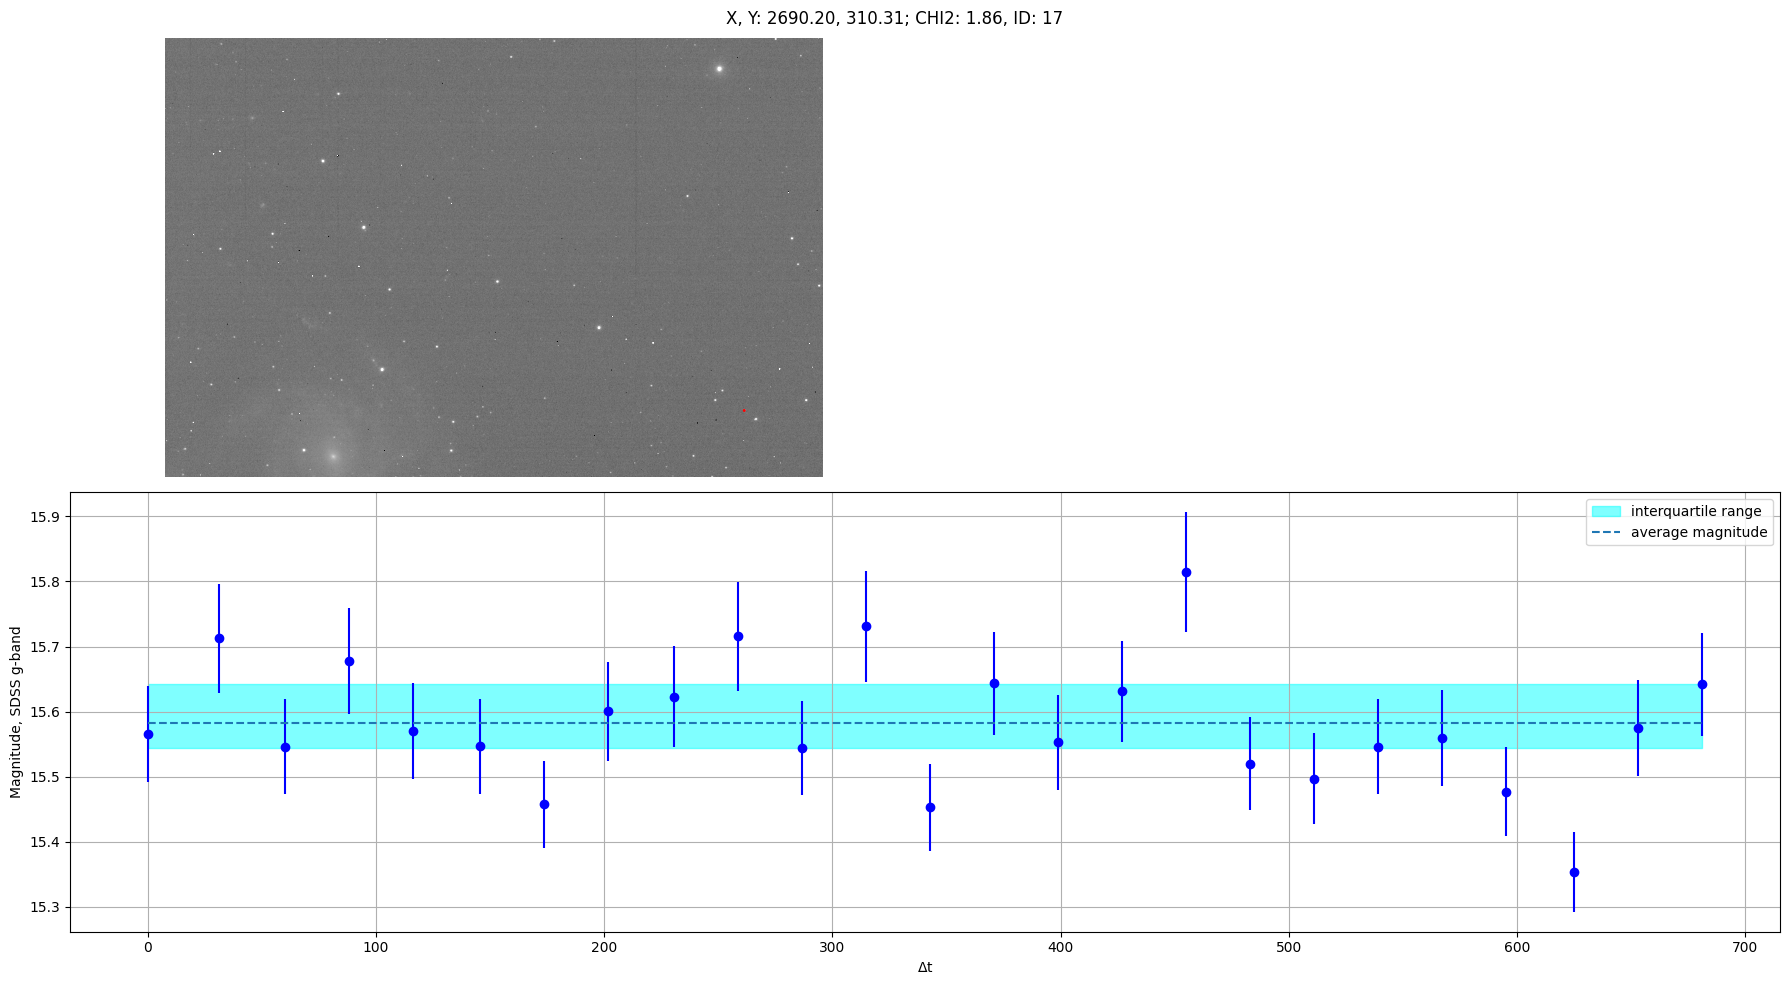

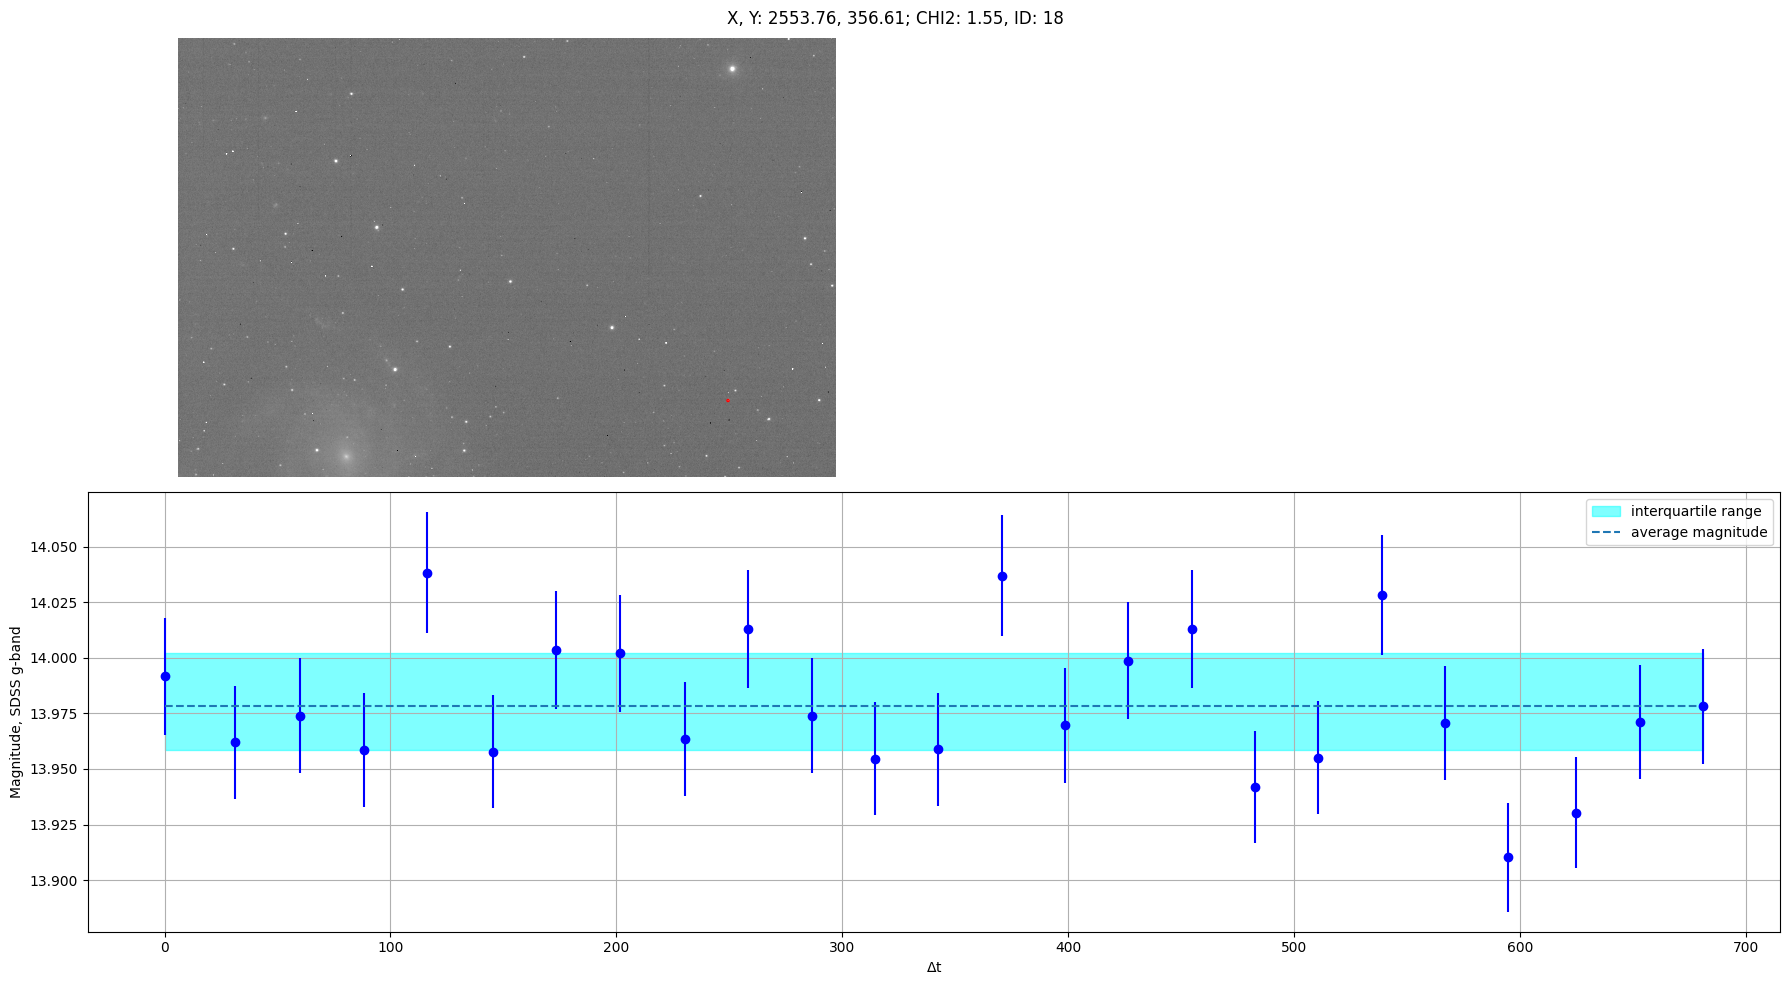

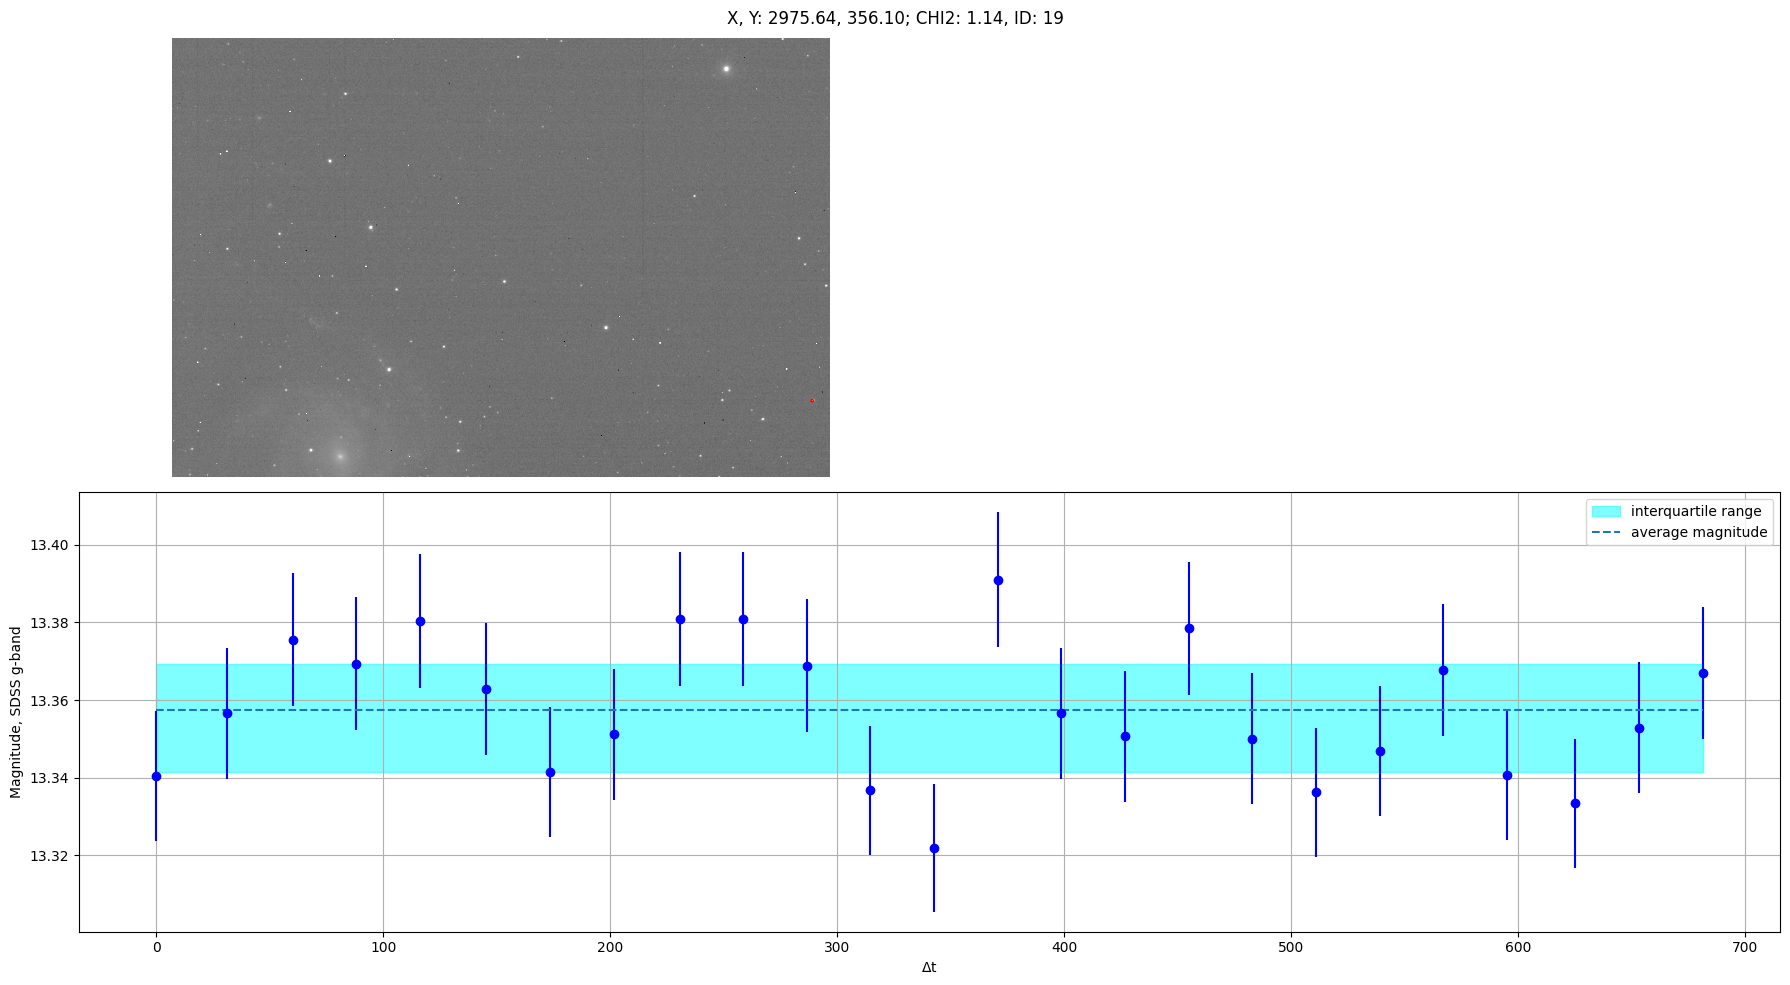

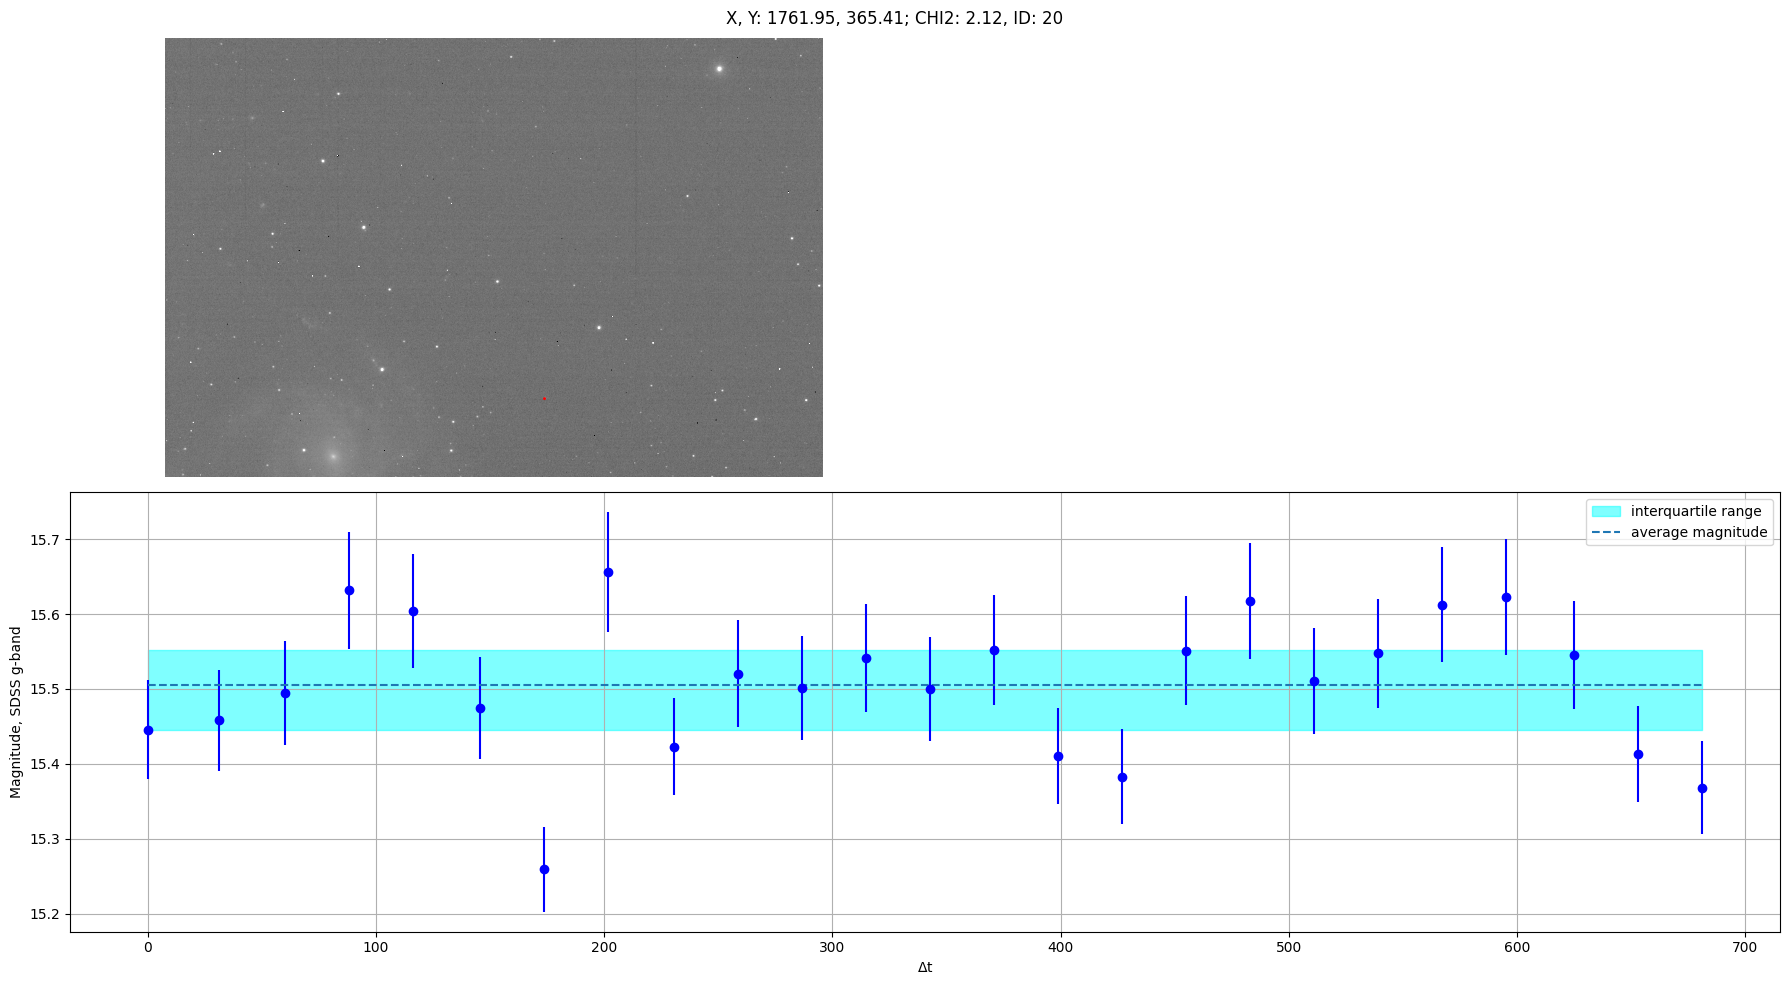

KeyboardInterrupt: 

In [27]:
for source in sources:
    mags = np.array(source['calibrated_mags'])
    mag_errs = np.array(source['inst_mag_errs'])
    times = Time(source['mjds'], format='mjd')
    calibrated_times = TimeSeries(time= times - np.min(times)).time.to('second').value #converts times to seconds since first observation begins
    avg_mag = np.mean(mags)
    source_iqr = iqr(mags)

    chisq = np.sum((mags - avg_mag)**2/mag_errs**2)
    dof = len(source['calibrated_mags']) - 1
    chi_dof = np.sum(chisq)/dof

    plt.figure(figsize=(18, 10))
    plt.suptitle("X, Y: {}, {}; CHI2: {}, ID: {}".format("%.2f" % source['x_coord'],"%.2f" % source['y_coord'], "%.2f" %chi_dof, source['source_id'] ))
    ax0 = plt.subplot(212)
    ax0.errorbar(calibrated_times, mags, yerr = mag_errs, linestyle = 'none', marker = 'o', color = 'b')
    ax0.hlines(y=avg_mag, xmin=calibrated_times[0], xmax=calibrated_times[-1], linestyle="dashed", label="average magnitude")
    ax0.grid()
    ax0.set_xlabel('$\Delta$t')
    ax0.set_ylabel("Magnitude, SDSS g-band")
    ax0.legend()

    ax1 = plt.subplot(221)
    circle = plt.Circle((source['x_coord'], source['y_coord']), source['rad'], color = 'r', fill = False)
    ax1.add_patch(circle)
    ax1.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')
    ax1.axis("off")

    ax2 = plt.subplot(222)
    # ax2.text(0, 0.5, s=statistics, fontsize=13)
    ax2.axis("off")

    # if abs(x_b - Mags[0]['x']) < 50 or abs(0-Mags[0]['x']) < 50:
    #     if abs(y_b - Mags[0]['y']) < 50 or abs(0-Mags[0]['y']) < 50:
    #         print("Border Warning")

    plt.tight_layout()
    # plt.savefig(os.path.join(out_path, f"lightcurve_{c}"))
    plt.show()

Luca's plots below >>>

for source in sources:
    r =  np.arange(0, len(source['calibrated_mags']), 1)
    plt.errorbar(r, source['calibrated_mags'], yerr = source['inst_mag_errs'], linestyle = 'none', marker = 'o', color = 'b')

    Chis = []
    avg_mag = np.mean(source['calibrated_mags'])
    for i, m in enumerate(source['calibrated_mags']):
        chi_i = ((m- avg_mag)**2)/(source['inst_mag_errs'][i]**2)
        Chis.append(chi_i)
    dof = len(source['calibrated_mags']) - 1
    chi_dof = np.sum(Chis)/dof
    #plt.title("X, Y: {}, {}; RA, DEC: {}, {}, CHI2: {}, ID: {}".format("%.2f" % source['x_coord'],"%.2f" % source['y_coord'],"%.4f" % source['ra'][0],"%.4f" % source['dec'][0], "%.2f" %chi_dof, source['source_id'] )) #get only to display a few decimal places
    plt.title("X, Y: {}, {}; CHI2: {}, ID: {}".format("%.2f" % source['x_coord'],"%.2f" % source['y_coord'], "%.2f" %chi_dof, source['source_id'] ))
    plt.plot(r, np.ones(len(r))*avg_mag, label = "TRIPP AVG MAG", linestyle = '--', color = 'b')
    if source['g_mag'] != None:
        if source['g_mag'] < 16:
            plt.plot(r, np.ones(len(r))*source['g_mag'], linestyle = '--', color = 'r', label = "SDSS MAG [REF]" )
        if source['g_mag'] >= 16:
            plt.plot(r, np.ones(len(r))*source['g_mag'], linestyle = '--', color = 'g', label = "SDSS MAG [NOT REF]" )

    plt.legend()
    # plt.savefig("/Users/lucaangeleri/Documents/LCO/SNM101plots/Source{}lightcurve.png".format(source['source_id']), format = 'png', dpi = 500)
    plt.show()

    plt.title("Source Number: {}, Position: {}, {}".format(source['source_id'], "%.2f" % source['x_coord'], "%.2f" % source['y_coord']))
    circle0 = plt.Circle((source['x_coord'], source['y_coord']), source['rad'], color = 'r', fill = False)
    circle1 = plt.Circle((source['x_coord'], source['y_coord']), source['rad'] + 5, color = 'b', fill = False)
    circle2 = plt.Circle((source['x_coord'], source['y_coord']), source['rad'] +5, color = 'g',fill = False)
    ax = plt.gca()
    ax.add_patch(circle0)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.imshow(template, cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')
    # plt.savefig("/Users/lucaangeleri/Documents/LCO/SNM101plots/Source{}location.png".format(source['source_id']), format = 'png', dpi = 500)
    plt.show()

